# Model Prediction Analysis

In [72]:
# Standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ieeg.auth import Session
from itertools import chain
import scipy as sc
from statannotations.Annotator import Annotator
from functools import reduce

# ML Imports
from sklearn.metrics import cohen_kappa_score, f1_score, matthews_corrcoef
import statsmodels.formula.api as smf

# OS imports
from os.path import join as ospj
from os.path import exists as ospe
from tqdm import tqdm
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
import os

In [73]:
plt.rcParams['image.cmap'] = 'magma'

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['xtick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['ytick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['xtick.minor.size'] = 3   # Change to your desired minor tick size
plt.rcParams['ytick.minor.size'] = 3   # Change to your desired minor tick size

plt.rcParams['xtick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['ytick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['xtick.minor.width'] = 1  # Change to your desired minor tick width
plt.rcParams['ytick.minor.width'] = 1  # Change to your desired minor tick width
pal = sns.color_palette('Set2')[:2][::-1] + ['grey']

In [74]:
usr,passpath,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,pt_list = load_config(ospj('/mnt/sauce/littlab/users/wojemann/stim-seizures/code','config.json'))

## Workspace Preparation

In [75]:
sz_metadata = pd.read_csv(ospj(metapath,'stim_seizure_information_BIDS.csv'))
sz_metadata.head()

,Unnamed: 0,Patient,IEEGname,EEC,UEO,Other_onset_description,approximate_onset,end,source,stim,stim_channels,EEC onset channels,UEO onset channels,Notes,to_annotate,typical,LVFA,Summaries,IEEGID
0,0,HUP224,HUP224_phaseII,71156.5913,71156.58349,NaN,71156.5900,71190.99,Will manual,1.0,LB1-LB2,"LB1,LB2,LB3,LB4,LB5,LC1,LC2,LC3,LC4,LA1,LA2,LA...",NaN,NaN,1.0,0.0,0.0,456.0,0.0
1,1,HUP224,HUP224_phaseII,202170.6825,202170.68250,NaN,202170.6800,202243.03,Erin manual,0.0,NaN,NaN,"RB2,RB3,RC2",NaN,NaN,NaN,NaN,34.0,0.0
2,2,HUP224,HUP224_phaseII,227267.9559,227267.95590,NaN,227267.9600,227350.65,Erin manual,0.0,NaN,NaN,"RB2,RB3,RC2",NaN,NaN,NaN,NaN,56.0,0.0
3,3,HUP224,HUP224_phaseII,339135.7773,339143.64350,NaN,339143.6435,339234.20,Erin manual,0.0,NaN,NaN,"RB2,RB3,RC2",NaN,1.0,NaN,NaN,NaN,0.0
4,4,HUP224,HUP224_phaseII,415736.8300,415751.71870,NaN,415751.7187,415805.57,Erin manual,0.0,NaN,NaN,NaN,no channels,NaN,NaN,NaN,NaN,0.0


In [206]:
# Loading seizure level metadata
# mdl_str = 'NRG'
# final_thresh = 0.415
# sz_annots = pd.read_pickle(ospj(prodatapath,f"optimized_predicted_channels_{mdl_str}_{final_thresh}.pkl"))
# sz_annots = pd.read_pickle(ospj(prodatapath,f"kdeknee_predicted_channels_opt_allpts.pkl"))
mdl_str = 'LSTM'
sz_annots = pd.read_pickle(ospj(prodatapath,f"optimized_predicted_channels_{mdl_str}_tuned_thresholds_v3.pkl"))
test = pd.read_pickle(ospj(prodatapath,f"optimized_predicted_channels_{mdl_str}_tuned_thresholds_v3_mean.pkl"))
print((test.threshold == sz_annots.threshold).sum()/len(test))
# sz_annots = sz_annots[sz_annots.Patient != 'HUP275']
sz_annots.columns = [col if col != 'Patient' else 'patient' for col in sz_annots.columns]
# sz_annots = sz_annots[sz_annots.Patient.apply(lambda x: x[:3] != 'CHO')]
sz_annots[sz_annots.patient.isin(['HUP238','HUP275'])]

1.0


,patient,iEEG_ID,model,stim,approximate_onset,offset,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,sec_chs_loose,sz_chs,sz_times,all_channels
158,HUP238,HUP238_phaseII,LSTM,1.0,10652.96973,10792.34,1.847797,"[LB01, LB02, LB03, LC04, LG03, LI01, LY10]","[LB01, LB02, LB03, LB04, LC04, LC05, LG03, LG0...","[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[8.5, 9.5, 8.5, 8.5, 37.0, 34.0, 0.0, 0.0, 0.0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0..."
159,HUP238,HUP238_phaseII,LSTM,0.0,290006.91000,290152.56,1.606020,"[LB01, LB02, LC01, LC02, LC03, LI01]","[LB01, LB02, LB03, LC01, LC02, LC03, LC04, LI0...","[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LC0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[1.5, 1.5, 1.5, 2.0, 30.0, 22.5, 0.0, 0.0, 0.5...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0..."
160,HUP238,HUP238_phaseII,LSTM,0.0,291463.71000,291655.33,1.606020,"[LB01, LB02, LC01, LC02, LC03, LI01, LU01]","[LB01, LB02, LB03, LC01, LC02, LC03, LC04, LI0...","[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LC0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[1.0, 2.5, 3.0, 4.0, 35.5, 29.0, 0.0, 0.0, 0.5...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0..."
161,HUP238,HUP238_phaseII,LSTM,0.0,294225.67940,294477.12,1.606020,"[LA01, LB01, LB02, LB03, LC01, LC02, LC03, LI0...","[LA01, LA02, LB01, LB02, LB03, LB04, LC01, LC0...","[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[0.0, 1.5, 3.0, 3.0, 25.5, 21.5, 0.0, 0.0, 0.0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0..."
162,HUP238,HUP238_phaseII,LSTM,0.0,337800.32000,337905.24,1.606020,[LC01],"[LC01, LC02]","[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LC0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[3.0, 3.0, 3.0, 3.0, 36.0, 28.0, 0.5, 0.5, 2.0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0..."
163,HUP238,HUP238_phaseII,LSTM,0.0,387404.80000,387462.36,1.606020,"[LB02, LB03, LC01, LC02]","[LB02, LB03, LB04, LC01, LC02, LC03]","[LB01, LB02, LB03, LC01, LC02, LC03, LG03, LI0...","[LB01, LB02, LB03, LB04, LC01, LC02, LC03, LC0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[11.0, 12.5, 10.5, 12.0, 34.5, 7.0, 0.0, 0.0, ...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0..."
164,HUP238,HUP238_phaseII,LSTM,0.0,412267.70000,412383.25,1.606020,"[LC01, LC02]","[LC01, LC02, LC03]","[LB01, LB02, LB03, LC01, LC02, LC03, LI01, LI0...","[LB01, LB02, LB03, LB04, LC01, LC02, LC03, LC0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[11.5, 12.0, 11.5, 11.5, 47.0, 44.0, 2.5, 2.0,...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0..."
165,HUP238,HUP238_phaseII,LSTM,0.0,465564.61000,465680.72,1.606020,"[LB01, LB02, LB03, LC01, LC02, LC03, LI01, LI02]","[LB01, LB02, LB03, LB04, LC01, LC02, LC03, LC0...","[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LC0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[7.0, 10.0, 7.5, 9.5, 54.5, 52.0, 0.0, 0.0, 0....","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0..."
166,HUP238,HUP238_phaseII,LSTM,0.0,484790.74000,484853.74,1.606020,"[LB01, LB02, LB03, LC01, LC02, LC03, LI01, LI02]","[LB01, LB02, LB03, LB04, LC01, LC02, LC03, LC0...","[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LC0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...","[5.5, 7.0, 5.5, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0..."
167,HUP238,HUP238_phaseII,LSTM,0.0,498683.08000,498806.98,1.606020,"[LB02, LC01, LC02, LC03, LI01, LI02]","[LB02, LB03, LC01, LC02, LC03, LC04, LI01, LI0...","[LA01, LA02, LA03, LA04, LB01, 

In [207]:
sz_annots[sz_annots.patient == 'HUP275'].ueo_chs_strict.iloc[-1]

array(['LA01', 'LA05', 'LA06', 'LA07', 'LA08', 'LI01'], dtype='<U4')

In [208]:
print(sz_annots.patient.nunique())
print(sz_annots[sz_annots.patient.apply(lambda x: 'HUP' in x)].patient.nunique())
print(len(sz_annots[sz_annots.patient.apply(lambda x: 'HUP' in x)]))
print(len(sz_annots[sz_annots.patient.apply(lambda x: 'CHOP' in x)]))
print(sz_annots[sz_annots.stim==1].approximate_onset.nunique())
print(sz_annots[sz_annots.patient.apply(lambda x: 'HUP' in x) & (sz_annots.stim==1)].approximate_onset.nunique())
print(sz_annots[sz_annots.patient.apply(lambda x: 'CHOP' in x) & (sz_annots.stim==1)].approximate_onset.nunique())

29
19
334
97
41
23
18


In [209]:
shared_channels = sz_annots.groupby('patient')['all_channels'].transform(lambda x: [list(set.intersection(*map(set, x)))] * len(x))
sz_annots['all_channels'] = shared_channels
sz_annots.sort_values('approximate_onset',inplace=True)

In [210]:
seizures_df = pd.read_csv(ospj(metapath,"stim_seizure_information - LF_seizure_annotation.csv"))
seizures_df.dropna(axis=0,how='all',inplace=True)
seizures_df.rename(columns=dict(Patient='patient',IEEGname='iEEG_ID'),inplace=True)
seizures_df['approximate_onset'].fillna(seizures_df['UEO'],inplace=True)
seizures_df['approximate_onset'].fillna(seizures_df['EEC'],inplace=True)
seizures_df['approximate_onset'].fillna(seizures_df['Other_onset_description'],inplace=True)
# drop HF stim induced seizures
seizures_df = seizures_df[seizures_df.stim != 2]
seizures_df.sort_values('approximate_onset',inplace=True)

## Seizure Annotation Preparation

### Merging annotations and seizure metadata

In [211]:
sz_annots = pd.merge_asof(sz_annots,
            seizures_df[['approximate_onset','patient',"iEEG_ID","typical","stim_channels"]],
            on='approximate_onset',by=['patient','iEEG_ID'],
            tolerance = 240,
            direction='nearest')

sz_annots.sort_values(['patient','iEEG_ID','approximate_onset'],inplace=True)

### Mapping channels to regions and adding stim channels

In [212]:
STIMFLAG = True # Toggle to include or remove stim channels from stim seizure onset zones
pt_groups = sz_annots.groupby('patient')
for pt,group in pt_groups:
    region_path = get_rpath(prodatapath,pt)
    if ospe(region_path):
        electrode_regions = pd.read_pickle(region_path)
        # electrode_regions = surgical_parcellation(electrode_regions)
    for idx,row in group.iterrows():
        if ospe(region_path):
                    sz_annots.at[idx,'all_rs'] = np.array([r for r in electrode_regions[electrode_regions.name.isin(row['all_channels'])]['label'].unique() if ((r != 'EmptyLabel') and ('white' not in r.lower()))])
                
        if STIMFLAG and row.stim == 1:
            stim_chs = clean_labels(row.stim_channels.split('-'),'')
            sz_annots.at[idx,'sz_chs'] = np.concatenate([row.sz_chs,stim_chs])
            sz_annots.at[idx,'sz_times'] = np.concatenate([row.sz_times,[0,0]])

        sz_annots.at[idx,'sz_rs'] = np.array([r for r in electrode_regions[electrode_regions.name.isin(row.sz_chs)]['label']])# if ((r != 'EmptyLabel') and ('white' not in r.lower()))])            

        for col in ['ueo_chs_strict', 'ueo_chs_loose', 'sec_chs_strict', 'sec_chs_loose']:
            chs = row[col]

            if STIMFLAG and row.stim == 1:
                chs = np.union1d(stim_chs,chs)
                sz_annots.at[idx,col] = chs
            # Creating channel mask
            sz_annots.at[idx,col+'_mask'] = np.array([ch in chs for ch in row['all_channels']])
            # Creating region labels and mask
            if ospe(region_path):
                # got rid of unique region tag after electrode_locals
                electrode_locals = np.array([r for r in electrode_regions[electrode_regions.name.isin(chs)]['label'] if ((r != 'EmptyLabel') and ('white' not in r.lower()))])
                sz_annots.at[idx,col.replace('chs','rs')+'_mask'] = np.array([l in electrode_locals for l in np.atleast_1d(sz_annots.loc[idx,'all_rs'])])
                sz_annots.at[idx,col.replace('chs','rs')] = electrode_locals
        # sz_annots.at[idx,'all_rs'] = electrode_regions[electrode_regions.name.isin(row['all_channels'])]['label'].unique()

sz_annots.dropna(axis=0,subset='stim',inplace=True)
sz_annots.sort_values(['approximate_onset'],inplace=True)


## Annotator Replication

### Seizure -- channel

In [218]:
def calculate_seizure_similarity(annots,first_annot = 'ueo_consensus', second_annot = 'ueo_consensus',paired=True):
    annot_list = ["kappa","F1","MCC","patient","spont","typical"]
    annot_dict = {key:[] for key in annot_list}
    skip_pt = []
    for pt,group in annots.groupby("patient"):
        if (sum(group.stim == 0) < 2) and paired:
            skip_pt.append(pt)
            continue
        elif len(group) < 2:
            skip_pt.append(pt)
            continue
        # Iterate through each seizure
        for i in range(len(group)):
            group.reset_index(drop=True,inplace=True)
            ch_mask = group.loc[i,first_annot].reshape(-1)
            for j in range(i+1,len(group)):
                if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
                    continue
                ch_mask2 = group.loc[j,second_annot].reshape(-1)
                annot_dict["kappa"].append(cohen_kappa_score(ch_mask,ch_mask2))
                annot_dict["F1"].append(f1_score(ch_mask,ch_mask2))
                annot_dict["MCC"].append(matthews_corrcoef(ch_mask,ch_mask2))
                annot_dict["spont"].append(not ((group.loc[i,'stim'] == 1)  or (group.loc[j,'stim'] == 1)))
                # want to append a boolean that will tell me if one sz is stim and one sz is typical
                annot_dict["typical"].append(((group.loc[i,'typical'] == 1)  
                                                        or (group.loc[j,'typical'] == 1)))
                annot_dict["patient"].append(pt)
    annot_df = pd.DataFrame(annot_dict)
    print(f"Skipped {skip_pt} due to insufficient spontaneous seizures")
    return annot_df

def calculate_spread_similarity(annots,first_annot = 'sz_chs', second_annot = 'sz_chs', sources = 'all_channels', spread_thresh = 30, paired=True):
    annot_list = ["MCC","Rank","patient","spont","typical"]
    annot_dict = {key:[] for key in annot_list}
    skip_pt = []
    for pt,group in annots.groupby("patient"):
        if (sum(group.stim == 0) < 2) and paired:
            skip_pt.append(pt)
            continue
        elif len(group) < 2:
            skip_pt.append(pt)
            continue
        # Iterate through each seizure
        for i in range(len(group)):
            group.reset_index(drop=True,inplace=True)
            # for each channel in sz_chs, is the time in sz_times less than spread_thresh, and if so set that channel to true
            ch_time_mask = [t < spread_thresh for t in group.loc[i,'sz_times']]
            if len(ch_time_mask) == 0:
                continue
            ch_mask = np.isin(group.loc[i,sources],group.loc[i,first_annot][ch_time_mask])

            onset_dict = dict(zip(group.loc[i,first_annot],group.loc[i,'sz_times']))
            max_latency = group.loc[i,'sz_times'].max() + 1
            all_latencies = np.array([onset_dict.get(ch,max_latency) for ch in group.loc[i,sources]])

            for j in range(i+1,len(group)):
                if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
                    continue
                ch_time_mask2 = [t < spread_thresh for t in group.loc[j,'sz_times']]
                if len(ch_time_mask2) == 0:
                    continue
                ch_mask2 = np.isin(group.loc[j,sources],group.loc[j,first_annot][ch_time_mask2])
                onset_dict2 = dict(zip(group.loc[j,first_annot],group.loc[j,'sz_times']))
                max_latency2 = group.loc[j,'sz_times'].max() + 1
                all_latencies2 = np.array([onset_dict2.get(ch,max_latency2) for ch in group.loc[j,sources]])

                annot_dict["MCC"].append(matthews_corrcoef(ch_mask,ch_mask2))
                annot_dict["Rank"].append(sc.stats.spearmanr(all_latencies,all_latencies2).statistic)
                annot_dict["spont"].append(not ((group.loc[i,'stim'] == 1)  or (group.loc[j,'stim'] == 1)))

                # want to append a boolean that will tell me if one sz is stim and one sz is typical
                annot_dict["typical"].append(((group.loc[i,'typical'] == 1)  
                                                        or (group.loc[j,'typical'] == 1)))
                annot_dict["patient"].append(pt)
    annot_df = pd.DataFrame(annot_dict)
    print(f"Skipped {skip_pt} due to insufficient spontaneous seizures")
    return annot_df

def plot_seizure_similarity(dat,agreement='MCC',palette=['red','blue','purple'],annot_type='',
                            sz_level=True, binary = False, typical = None, combiner = 75,
                            annot_stats=True):
    if typical is not None:
        all_groups = []
        for _, group in dat.groupby(['patient']):
            stims = group.loc[(group.spont==False) & (group.typical == typical),:]

            if len(stims) == 0:
                continue
            
            all_groups.append(pd.concat([stims,group.loc[group.spont,:]],axis=0))

        dat = pd.concat(all_groups, axis=0)

    def percentile(x,combiner=combiner):
        # return np.percentile(x,combiner,method='linear')
        return np.mean(x)
    # Define the aggregation functions
    numeric_cols = dat.select_dtypes(include='number').columns
    non_numeric_cols = dat.select_dtypes(exclude='number').columns.difference(['patient', 'spont'])
    

    if (agreement == 'Rank'):
        dat = dat[~dat.isna().any(axis=1)]

    pt_data = dat.groupby(['patient', 'spont']).agg(
        {col: percentile for col in numeric_cols} |
        {col: 'max' for col in non_numeric_cols}
    ).reset_index()

    # pt_data = data.groupby(["patient","spont"])[["kappa","F1"]].apply(agg_funcs).reset_index()
    fig,ax = plt.subplots(figsize=(4,5))
    if sz_level:
        model = smf.mixedlm(f"{agreement} ~ C(spont)", dat, groups="patient")
        result = model.fit()
        print(result.summary())
        print(result.pvalues)
        plot_data = dat
        plt.title(f"Seizure-Level Seizure{annot_type} Similarity")

    else:
        plot_data = pt_data
        _,p = sc.stats.ttest_rel(pt_data[~pt_data.spont][agreement],pt_data[pt_data.spont][agreement])
        if binary:
            cont = pd.crosstab(pt_data.spont,pt_data[agreement])
            res = sc.stats.chi2_contingency(cont)
            p = res.pvalue
            print(res)
            fig1,ax1 = plt.subplots()
            sns.heatmap(cont,annot=True,robust=True,
                        xticklabels=True,yticklabels=True,
                        cmap=sns.light_palette("seagreen", as_cmap=True),
                        ax=ax1,
                        cbar=False)
            ax1.set_yticks([0.5,1.5],["Stim-Spont","Spont-Spont"])
            ax1.set_xlabel("Region Agreement?")
            ax1.set_ylabel("")
            fig1.savefig(ospj(figpath,"one_onset_region_boxes.pdf"))
        d = cohens_d(pt_data[~pt_data.spont][agreement],pt_data[pt_data.spont][agreement])
        print(f"Paired t-test - p: {p}, d: {d}")
        ax.set_title(f"Patient-Level Seizure{annot_type} Similarity")

    ax = sns.pointplot(data=plot_data,x="spont",y=agreement,
                errorbar=None,
                markers="_",
                linestyles="none",
                palette=palette[:2],
                estimator=np.mean,
                linewidth=4,
                markersize=45,
                ax=ax)
    # plt.setp(ax.lines, linewidth=20)
    sns.swarmplot(data=plot_data,x="spont",y=agreement,
                alpha=.7,
                palette = palette[:2],
                ax=ax
                # hue='patient'
                )
    if annot_stats:
        annotator = Annotator(ax,[(True,False)],data=plot_data,x='spont',y=agreement)
        annotator.configure(test='t-test_paired',loc='outside',text_format='star')
        annotator.apply_and_annotate()

    plt.ylim([-0.25,1.15])
    sns.despine()
    ax.set_xticks([0,1],["Stim Induced","Spontaneous"])
    ax.set_xlabel('')
    ax.set_ylabel(f"Seizure Agreement ({agreement})")

    return fig

In [214]:
def plot_ks_similarity(data,palette = ['red','blue','purple']):
    def ks_function(group):
        stat,p = sc.stats.kstest(group[group.spont == False].F1,group[group.spont].F1)
        return pd.DataFrame(np.array([p,p < 0.05,stat,group.patient.to_list()[0]]).reshape(1,-1),columns=['pvalue','sig','KS','patient'])
    
    plot_data = data.groupby('patient').apply(ks_function)
    plot_data.loc[:,'pvalue'] = plot_data.loc[:,'pvalue'].astype(float)
    plot_data.loc[:,'sig'] = plot_data.loc[:,'sig'] == 'True'
    plot_data.loc[:,'KS'] = plot_data.loc[:,'KS'].astype(float)

    ax = sns.pointplot(data=plot_data,y='pvalue',errorbar=None,
                markers="_",linestyles="none",
                color='purple',
                # color='black',
                estimator=np.median,
                linewidth=4,
                markersize=45,
                )
                
    # plt.setp(ax.lines, linewidth=20)
    sns.swarmplot(data=plot_data,
                y='pvalue',
                alpha=.7,
                palette = palette[:2],
                ax=ax,
                hue='sig'
                )
    sns.despine()


In [215]:
ch_similarity_df = calculate_seizure_similarity(sz_annots,first_annot='ueo_chs_strict_mask',second_annot='ueo_chs_strict_mask',paired=True)

Skipped ['HUP229', 'HUP246'] due to insufficient spontaneous seizures


In [216]:
# plot_ks_similarity(ch_similarity_df)

Paired t-test - p: 0.07265533085020436, d: -0.3874045883457291
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test paired samples, P_val:7.266e-02 t=-1.871e+00


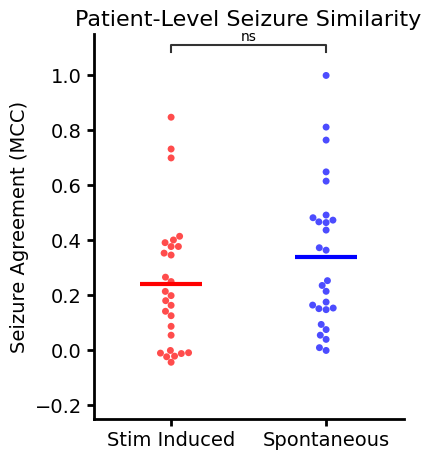

In [219]:
fig = plot_seizure_similarity(ch_similarity_df,agreement='MCC',sz_level=False,typical=None,annot_stats=True,combiner=90)
fig.savefig(ospj(figpath,"ch_sz_similarity.pdf"))

In [147]:
all_stim_annots = []
all_spont_annots = []
annot_type = 'ueo'
con_type = 'loose'
example_pt = 'HUP257'
group = sz_annots[sz_annots.patient == example_pt]
group.sort_values(ascending=False,by='stim',inplace=True)
kappa_mat = np.zeros((len(group),len(group))); kappa_mat[:] = np.nan
group.reset_index(drop=True,inplace=True)
for i in range(len(group)):
    ch_mask = group.loc[i,f'{annot_type}_chs_{con_type}_mask']
    if group.loc[i,'stim'] == 1:
        print(f"{i} is stim")
    for j in range(i+1,len(group)):
        ch_mask2 = group.loc[j,f'{annot_type}_chs_{con_type}_mask']
        kappa_mat[i,j] = cohen_kappa_score(ch_mask,ch_mask2)

0 is stim


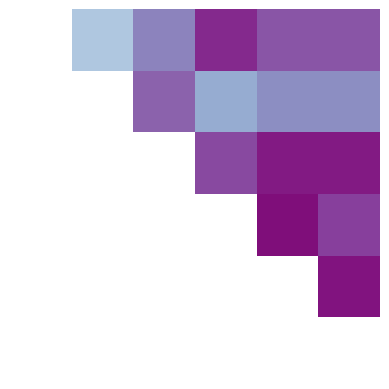

In [148]:
import matplotlib.patches as patches
fig,ax = plt.subplots()
plt.imshow(kappa_mat,cmap = 'BuPu')
# plt.colorbar()
plt.clim(0,1)
plt.xticks([])
plt.yticks([])
for spine in ax.spines.values():
            spine.set_visible(False)
plt.savefig(ospj(figpath,f'ueo_heatmap_pt-{example_pt}.pdf'),bbox_inches='tight')

In [90]:
# ch_spread_similarity_df = calculate_spread_similarity(sz_annots,first_annot='sz_chs',second_annot='sz_chs',paired=True)

In [91]:
# _ = plot_seizure_similarity(ch_spread_similarity_df,sz_level=False,agreement='MCC')

### Seizure -- region

In [92]:
sz_annots_rs = sz_annots.dropna(axis=0,subset=['all_rs'])

In [93]:
sz_annots_rs

,patient,iEEG_ID,model,stim,approximate_onset,offset,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,ueo_rs_strict,ueo_chs_loose_mask,ueo_rs_loose_mask,ueo_rs_loose,sec_chs_strict_mask,sec_rs_strict_mask,sec_rs_strict,sec_chs_loose_mask,sec_rs_loose_mask,sec_rs_loose
0,CHOP026,CHOP026,LSTM,0.0,771.890,797.89,1.606020,[LO03],"[LO03, LO04]","[LM01, LM02, LM03, LM04, LN01, LN02, LN03, LN0...",...,[Left-Hippocampus],"[False, False, False, False, False, False, Fal...","[False, True, False, False, False, False, Fals...","[Left-Hippocampus, Left-Hippocampus]","[False, False, False, False, False, False, Fal...","[True, True, False, False, False, False, False...","[Left-Amygdala, Left-Amygdala, Left-Amygdala, ...","[False, False, False, False, False, False, Fal...","[True, True, False, False, False, False, False...","[Left-Amygdala, Left-Amygdala, Left-Amygdala, ..."
1,HUP229,HUP229_phaseII,LSTM,1.0,1109.400,1176.91,3.588785,"[LA02, LB01, LB02, LB03, LB04, LC01, LC02, LC0...","[LA02, LA03, LB01, LB02, LB03, LB04, LB05, LC0...","[LA01, LA02, LA03, LB01, LB02, LB03, LB04, LC0...",...,"[ left amygdala , left hippocampus , left hi...","[False, False, False, False, False, False, Tru...","[True, False, False, True, True, False, True, ...","[ left amygdala , left hippocampus , left hi...","[False, False, False, False, False, False, Fal...","[True, True, False, True, True, False, True, F...","[ left amygdala , left amygdala , left hippo...","[False, False, False, False, False, False, Tru...","[True, True, False, True, True, False, True, F...","[ left amygdala , left amygdala , left super..."
2,CHOP035,CHOPCCEP_035,LSTM,1.0,2872.350,2899.06,3.097463,"[LG01, LG02, LG03, LG04, LL01, LL02, LL03, LL0...","[LG01, LG02, LG03, LG04, LG05, LL01, LL02, LL0...","[LF02, LF03, LG01, LG02, LG03, LG04, LL01, LL0...",...,"[ctx-lh-parahippocampal, ctx-lh-insula, ctx-lh...","[False, True, False, False, False, False, Fals...","[True, True, True, False, False, True, True, F...","[ctx-lh-parahippocampal, ctx-lh-insula, ctx-lh...","[False, True, False, False, False, False, Fals...","[True, True, False, False, False, True, True, ...","[ctx-lh-parahippocampal, ctx-lh-insula, Left-A...","[False, True, False, False, False, False, Fals...","[True, True, False, False, False, True, True, ...","[ctx-lh-parahippocampal, ctx-lh-insula, ctx-lh..."
3,CHOP026,CHOPCCEP_026,LSTM,1.0,3608.770,3742.56,2.841121,"[LH09, LH10, LN05]","[LH09, LH10, LN05, LN06]","[LH05, LH09, LH10]",...,"[Left-Hippocampus, ctx-lh-parsopercularis]","[False, False, False, False, False, False, Fal...","[False, True, False, False, False, False, Fals...","[Left-Hippocampus, Left-Hippocampus, ctx-lh-pa...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",[ctx-lh-parsopercularis],"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",[ctx-lh-parsopercularis]
4,HUP230,HUP230_phaseII,LSTM,1.0,3860.240,3878.40,2.189586,"[LB05, LB06, LC01, LC02]","[LB05, LB06, LC01, LC02, LC03]","[LB05, LB06, LC01, LC02, LM04]",...,"[ left superior temporal , left parahippocamp...","[False, False, False, False, False, False, Fal...","[False, False, True, False, False, False, Fals...","[ left superior temporal , left parahippocamp...","[False, False, False, False, False, False, Fal...","[False, False, True, False, False, False, Fals...","[ left superior temporal , left parahippocamp...","[False, False, False, False, False, False, Fal...","[False, False, True, False, False, False, Fals...","[ left superior temporal , left parahippocamp..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,HUP247,HUP247_phaseII,LSTM,0.0,577555.030,577574.76,1.436582,"[RP01, RP02, RP03, RP04, RV04, RV05, RV06, RV0...","[RP01, RP02, RP03, RP04, RP05, RV04, RV05, RV0...","[RP01, RP02, RP03, RP04, RV04, RV05, RV07, RV0...",...,"[ right precuneus , right precuneus , right ...","[True, True, True, True,

In [94]:
r_similarity_df = calculate_seizure_similarity(sz_annots_rs,first_annot='ueo_rs_loose_mask',second_annot='ueo_rs_loose_mask')

Skipped ['HUP229', 'HUP246'] due to insufficient spontaneous seizures


Paired t-test - p: 0.0006164610035249626, d: -0.8050191320159471
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test paired samples, P_val:6.165e-04 t=-3.894e+00


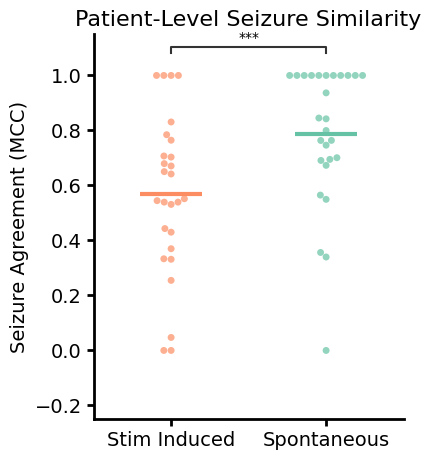

In [95]:
fig = plot_seizure_similarity(r_similarity_df,agreement='MCC',palette=pal,sz_level=False,typical=None,combiner=90)
fig.savefig(ospj(figpath,"region_sz_similarity.pdf"))

### Region spread

In [96]:
# r_spread_similarity_df = calculate_spread_similarity(sz_annots,first_annot='sz_rs',second_annot='sz_rs',sources='all_rs')

In [97]:
# r_spread_similarity_df

In [98]:
# fig = plot_seizure_similarity(r_spread_similarity_df,agreement='MCC',palette=pal,sz_level=False)

### Bootstrapping

In [99]:
# print(sz_annots_rs.iloc[-1,-1],sz_annots_rs.iloc[-1,8])

In [100]:
# def boot_function(input_region,n_boots=1000):
#     np.random.seed(0)
#     seizure_counts = {}
#     n_boots = 1000
#     regions = np.atleast_1d(input_region).reshape(-1,)
#     # Perform 100 bootstraps
#     for _ in range(n_boots):
#         bootstrap_sample = np.random.choice(regions, size=len(regions), replace=True)
#         for region in np.unique(bootstrap_sample):
#             if region in seizure_counts:
#                 seizure_counts[region] += 1
#             else:
#                 seizure_counts[region] = 1

#     # Calculate the probability of each region being the true seizure region
#     probabilities = {region: count / n_boots for region, count in seizure_counts.items()}
#     most_likely = max(probabilities, key = probabilities.get) if len(probabilities)>0 else []
#     # return np.array([key for key in probabilities.keys() if probabilities[key] > 0.75])
#     return most_likely

# def mask_function(row):
#     return np.array([l in row.ueo_rs_boot for l in np.atleast_1d(row.all_rs)])
    

In [101]:
# sz_annots_rs['ueo_rs_boot'] = sz_annots_rs['ueo_rs_strict'].apply(boot_function)

In [102]:
# def surgical_parcelate(region_list):
#     surgical_labels = []
#     for label in np.atleast_1d(region_list):
#         if isinstance(label,float):
#             label = "EmptyLabel"
#         label = label.lower()
#         if ("emptylabel" in label) or ("white" in label):
#             surgical_label = "EmptyLabel"
#         elif ("amygdala" in label) or ("hippocampus" in label):
#             if "left" in label:
#                 surgical_label = 'left mesial temporal'
#             else:
#                 surgical_label = 'right mesial temporal'
#         elif ("temporal" in label) or ("fusiform" in label) or ("entorhinal" in label) or ("parahippocampal" in label):
#             if "left" in label:
#                 surgical_label = 'left temporal neocortex'
#             else:
#                 surgical_label = 'right temporal neocortex'
#         else:
#             if "left" in label:
#                 surgical_label = 'left other neocortex'
#             else:
#                 surgical_label = 'right other neocortex'
#         surgical_labels.append(surgical_label)
#     return surgical_labels

In [103]:
# sz_annots_rs['ueo_rs_boot_mask'] = sz_annots_rs.apply(mask_function,axis=1)

In [104]:
# boot_similarity_df = calculate_seizure_similarity(sz_annots_rs,first_annot='ueo_rs_boot_mask',second_annot='ueo_rs_boot_mask')

In [105]:
# plot_seizure_similarity(boot_similarity_df,agreement='F1',palette=pal,sz_level=False, binary=True)

## Seizure spread timing

### Channels

In [106]:
time_points =  np.arange(0,60.5,0.5)
def calculate_fraction(seizure_times, time_points = np.arange(0,60.5,.5)):
    fractions = []
    num_channels = seizure_times.shape[1]
    for t in time_points:
        fraction_seizing = (np.sum((seizure_times <= t) & (seizure_times >=0), axis=1)-np.sum(seizure_times < 0,axis=1)) / (num_channels-np.sum(seizure_times < 0,axis=1))
        fractions.append(fraction_seizing)
    return np.array(fractions).T  # Transpose to have seizures as rows and time points as columns

In [107]:
# Now need to iterate through patinets, then iterate through seizures that are stim
all_pts = []
all_fraction_ts = []
for pt,group in sz_annots.groupby("patient"):
    stim_szs = group[group.stim == 1]
    spont_szs = group[group.stim == 0]
    for idx,st_sz in stim_szs.iterrows():
        # Now, for each stim seizure I want to iterate through each spontaneous seizure:
        onset_locs = st_sz.ueo_chs_strict # can change to other channel types but this makes the most sense
        if len(onset_locs.shape) == 0:
            onset_locs = np.array([str(onset_locs)])
        all_st_sp_spreads = np.ones((len(spont_szs),len(onset_locs)))*60000
        for j,(idx,sp_sz) in enumerate(spont_szs.iterrows()):
            # For each spontaneous seizure, find the time when the stim seizure onset regions start seizing (if ever)
            locs = sp_sz.sz_chs
            times = sp_sz.sz_times
            # all_pts.append(pt) # SEIZURE LEVEL
            for k,st_loc in enumerate(onset_locs):
                loc_idx = st_loc == locs
                if (loc_idx is not pd.NA) and (np.sum(loc_idx) > 0):
                    all_st_sp_spreads[j,k] = times[loc_idx]
            # This gives me an array that is spont seizures x stim onset channels and each element is the time that the spont seizure started seizing in that stim onset channel
            # I can try averaging across stim onset times for those that it started seizing in?
            # I can also just treat it as an independent data point to plot
        fraction_ts = calculate_fraction(all_st_sp_spreads,time_points)
        # all_fraction_ts.append(fraction_ts) # SEIZURE LEVEL
        all_pts.append(pt)
        all_fraction_ts.append(np.mean(fraction_ts,axis=0))

stim_spread_df = pd.DataFrame(np.array(all_fraction_ts),columns=time_points)
nan_idxs = stim_spread_df.isna().any(axis=1)
stim_spread_df = stim_spread_df.loc[~nan_idxs,:]
# stim_spread_df = pd.DataFrame(np.concatenate(all_fraction_ts,axis=0),columns=time_points) # SEIZURE LEVEL
stim_spread_df['patient'] = np.array(all_pts)[~nan_idxs]

stim_spread_df_long = stim_spread_df.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')

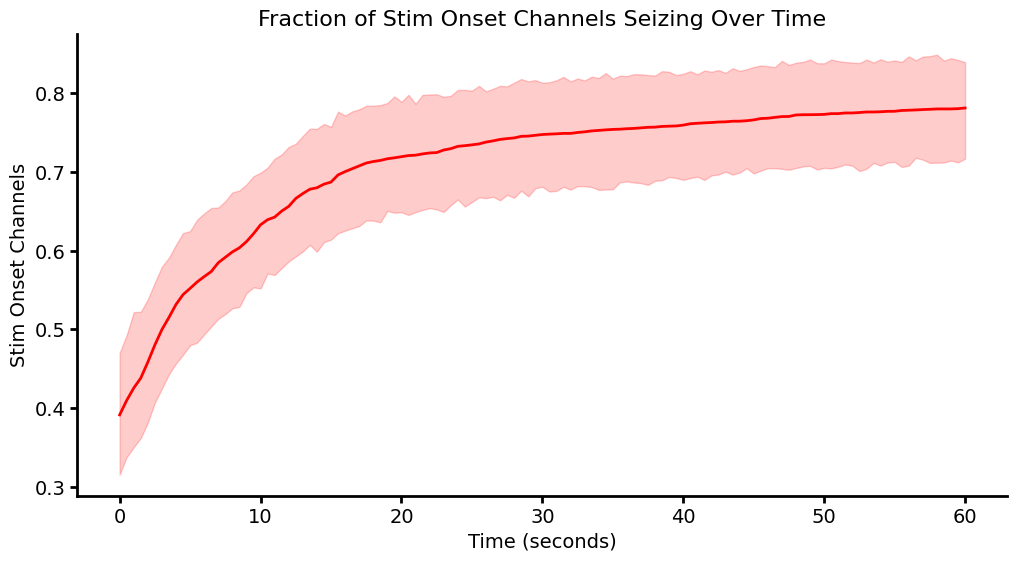

In [108]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=stim_spread_df_long, x='Time', y='Fraction',color='red')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 0]['Fraction'].mean(),color='red',linestyle='--')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 15]['Fraction'].mean(),color='blue',linestyle='--')
plt.title('Fraction of Stim Onset Channels Seizing Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Stim Onset Channels')
sns.despine()
# plt.ylim((0,1))

#### Null modeling

Need to figure out what are the odds of a random selection of regions equal to the number of stim onset regions seizing at that time point. This should sample from the all_rs based on the number of stim UEO regions

In [109]:
set_seed(2358)
# Now need to iterate through patinets, then interate through seizures that are stim
all_pts = []
null_fraction_ts = []
for pt,group in sz_annots.groupby("patient"):
    stim_szs = group[group.stim == 1]
    spont_szs = group[group.stim == 0]
    for idx,st_sz in stim_szs.iterrows():
        onset_locs = st_sz.ueo_chs_strict # can change to other channel types but this makes the most sense
        if len(onset_locs.shape) == 0:
            onset_locs = np.array([str(onset_locs)])
        null_n = len(onset_locs)
        for _ in range(50):
            if null_n == 0:
                null_locs = []
            else:
                sample_chs = np.array([r for r in np.atleast_1d(st_sz.all_channels)])
                null_locs = sample_chs[np.random.randint(0,len(sample_chs),null_n)]
            null_st_sp_spreads = np.ones((len(spont_szs),len(null_locs)))*60000
            for j,(idx,sp_sz) in enumerate(spont_szs.iterrows()):
                # For each spontaneous seizure, find the time when the stim seizure onset regions start seizing (if ever)
                locs = sp_sz.sz_chs
                times = sp_sz.sz_times
                # all_pts.append(pt) # SEIZURE LEVEL
                for k,st_loc in enumerate(null_locs):
                    loc_idx = st_loc == locs
                    if (loc_idx is not pd.NA) and (np.sum(loc_idx) > 0):
                        null_st_sp_spreads[j,k] = times[loc_idx]
            fraction_ts = calculate_fraction(null_st_sp_spreads,time_points)
            # null_fraction_ts.append(fraction_ts) # SEIZURE LEVEL
            null_fraction_ts.append(np.mean(fraction_ts,axis=0))
            all_pts.append(pt) 
null_spread_df = pd.DataFrame(np.array(null_fraction_ts),columns=time_points)

# null_spread_df = pd.DataFrame(np.concatenate(null_fraction_ts,axis=0),columns=time_points) # SEIZURE LEVEL
null_spread_df['patient'] = all_pts

null_spread_df_long = null_spread_df.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')


In [110]:
is_sig = np.zeros((len(time_points),),dtype=bool)
for i,t in enumerate(time_points):
    stim_dist = stim_spread_df_long[stim_spread_df_long.Time == t]['Fraction']
    null_dist = null_spread_df_long[null_spread_df_long.Time == t]['Fraction']
    # pval = sc.stats.ttest_ind(stim_dist,null_dist,alternative='greater')[1]
    pval = (np.sum(null_dist > np.mean(stim_dist))+1)/(len(null_dist)+1)
    print(pval)
    if pval < 0.05:
        is_sig[i] = True


0.10970258410531449
0.11555338859093126
0.11604095563139932
0.12335446123842028
0.1189663578742077
0.12286689419795221
0.12774256460263286
0.12286689419795221
0.12676743052169673
0.1296928327645051
0.13505607020965382
0.13310580204778158
0.13505607020965382
0.14285714285714285
0.14480741101901512
0.15699658703071673
0.1599219892735251
0.16382252559726962
0.16235982447586544
0.16479765967820575
0.17601170160897123
0.18088737201365188
0.18430034129692832
0.18722574353973673
0.1886884446611409
0.18917601170160897
0.1779619697708435
0.17942467089224767
0.1803998049731838
0.181862506094588
0.18527547537786446
0.1847879083373964
0.18673817649926866
0.18722574353973673
0.1886884446611409
0.1886884446611409
0.18966357874207704
0.1901511457825451
0.1901511457825451
0.19063871282301317
0.19161384690394928
0.19210141394441735
0.19210141394441735
0.19210141394441735
0.19210141394441735
0.19405168210628962
0.1955143832276938
0.19600195026816186
0.1955143832276938
0.19648951730862993
0.1964895173086

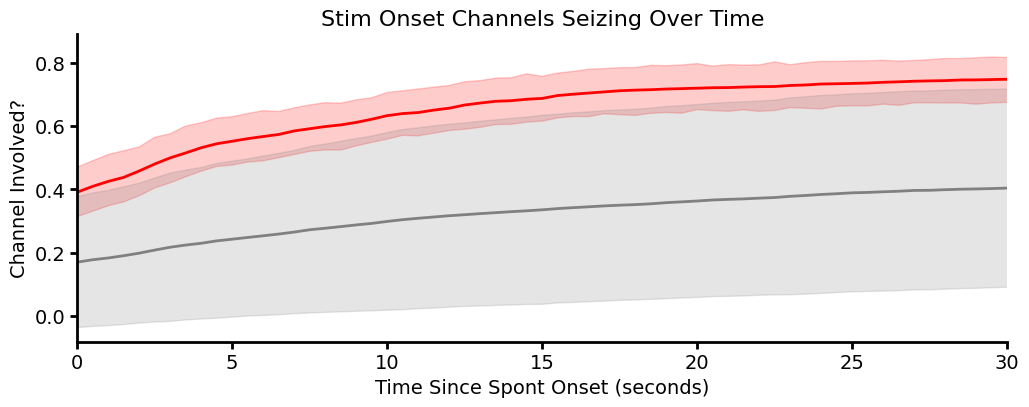

In [111]:
fig,ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=stim_spread_df_long, x='Time', y='Fraction',color='red')
sns.lineplot(data=null_spread_df_long, x='Time', y='Fraction',color='grey',errorbar=('sd',1))#,errorbar=lambda x: (np.percentile(x,5),np.percentile(x,75)))
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 0]['Fraction'].mean(),color='red',linestyle='--')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 15]['Fraction'].mean(),color='blue',linestyle='--')
plt.title('Stim Onset Channels Seizing Over Time')
plt.xlabel('Time Since Spont Onset (seconds)')
plt.ylabel('Channel Involved?')
sns.despine()
plt.xlim((0,30))
# plt.ylim((.8,1.05))
# for i in range(len(is_sig) - 1):
#     if is_sig[i]:
#         if is_sig[i + 1]:
#             ax.hlines(1, time_points[i], time_points[i + 1], color='k', linewidth=2)
#         else:
#             ax.hlines(1, time_points[i], time_points[i], color='k', linewidth=2)
ymin,ymax = plt.ylim()
if sum(is_sig) > 0:
    star_x = np.where(is_sig)[0][0]
    plt.text(time_points[star_x],ymax-.025,'*',fontsize='24',horizontalalignment='center')
    plt.vlines(time_points[star_x],ymin,ymax-.025,ls='--',color='k')
plt.savefig(ospj(figpath,'stim_ueo_ch_recruitment.pdf'),bbox_inches='tight')

In [112]:
# Now need to iterate through patients, then interate through seizures that are stim
all_pts = []
spont_fraction_ts = []
for pt,group in sz_annots.groupby("patient"):
    spont_szs = group[group.stim == 0]
    for idx,key_sz in spont_szs.iterrows():
        # Now, for each spontatneous seizure I want to iterate through each other spontaneous seizure:
        onset_locs = key_sz.ueo_chs_strict
        if len(onset_locs.shape) == 0:
            onset_locs = np.array([str(onset_locs)])
        
        all_st_sp_spreads = np.ones((len(spont_szs),len(onset_locs)))*60000
        for j,(idx,sp_sz) in enumerate(spont_szs.iterrows()):
            # For each spontaneous seizure, find the time when the stim seizure onset regions start seizing (if ever)
            locs = sp_sz.sz_chs
            times = sp_sz.sz_times
            for k,key_loc in enumerate(onset_locs):
                loc_idx = key_loc == locs
                if (loc_idx is not pd.NA) and (np.sum(loc_idx) > 0):
                    all_st_sp_spreads[j,k] = times[loc_idx]
        fraction_ts = calculate_fraction(all_st_sp_spreads,time_points)
        if np.isnan(fraction_ts).any():
            continue
        # spont_fraction_ts.append(fraction_ts)
        # all_pts.append([pt]*len(fraction_ts))
        spont_fraction_ts.append(np.nanmean(fraction_ts,axis=0))
        all_pts.append(pt)

spont_spread_df = pd.DataFrame(np.array(spont_fraction_ts),columns=time_points)
spont_spread_df['patient'] = all_pts
spont_spread_df_long = spont_spread_df.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')

In [113]:
is_sig = np.zeros((int(60/1),),dtype=bool)
for i,t in enumerate(np.arange(0,60,1)):
    spont_dist = spont_spread_df_long[spont_spread_df_long.Time == 0]['Fraction']
    stim_dist = stim_spread_df_long[stim_spread_df_long.Time == t]['Fraction']
    pval = sc.stats.ttest_ind(spont_dist,stim_dist,alternative='greater')[1]
    if pval < 0.05:
        is_sig[i] = True

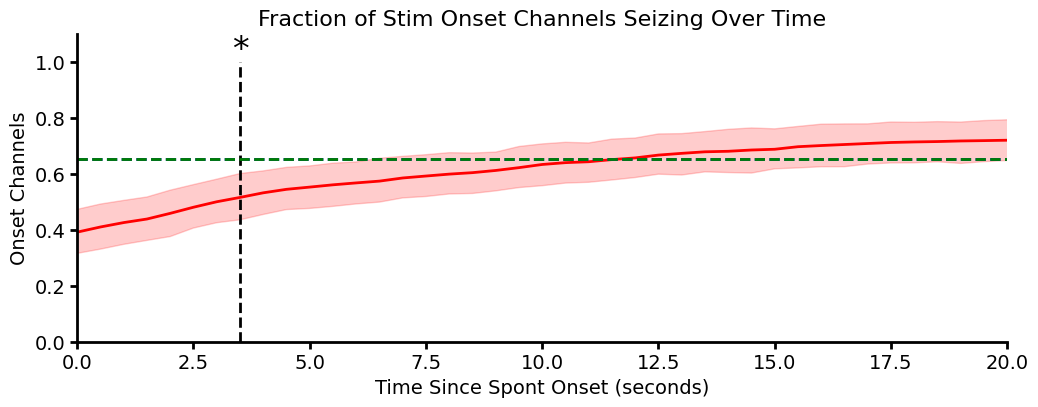

In [114]:
fig,ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=stim_spread_df_long, x='Time', y='Fraction',color='red',linewidth=2,err_style='band')
# sns.lineplot(data=spont_spread_df_long, x='Time', y='Fraction',color='green',linewidth=2,err_style='band')
plotting_df = spont_spread_df_long.copy()
plotting_df = plotting_df[plotting_df.Time==0]
plotting_df.loc[:,'Time'] = -2
# sns.lineplot(data=null_spread_df_long, x='Time', y='Fraction',color='grey',linewidth=2)
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 0]['Fraction'].mean(),color='red',linestyle='--')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 15]['Fraction'].mean(),color='blue',linestyle='--')
plt.title('Fraction of Stim Onset Channels Seizing Over Time')
plt.xlabel('Time Since Spont Onset (seconds)')
plt.ylabel('Onset Channels')
sns.despine()
plt.xlim((0,20))
plt.ylim((0,1.1))
# Plot horizontal bars at y = 0.05
# for i in range(len(is_sig) - 1):
#     if is_sig[i]:
#         if is_sig[i + 1]:
#             ax.hlines(1, time_points[i], time_points[i + 1], color='k', linewidth=2)
#         else:
#             ax.hlines(1, time_points[i], time_points[i], color='k', linewidth=2)
star_x = np.where(is_sig)[0][-1]
plt.hlines(spont_spread_df_long[spont_spread_df_long.Time == 0]['Fraction'].mean(),0,60,colors='blue',linestyles='--',linewidth=2)
plt.text(time_points[star_x],1.01,'*',fontsize='24',horizontalalignment='center')
ymin,ymax = plt.ylim()
plt.vlines(time_points[star_x],ymin,1,ls='--',color='k')
plt.hlines(spont_spread_df_long[spont_spread_df_long.Time == 0]['Fraction'].mean(),0,60,colors='green',linestyles='--',linewidth=2)
plt.savefig(ospj(figpath,'spont-stim_ueo_channel_recruitment.pdf'),bbox_inches='tight')

### Regions

Goal is to create a lineplot with error bar that has the percent of the stim seizure onset zone channels recruited on the y axis and the time since onset on the x axis.
For each stim seizure I need to create that signal. Really i'll have a signal for each stim-spont pair
If I have the time varying % seizing signal for each stim-spont pair I can calculate average across time for a stim seizure
Need to change each 
For each stim seizure:
    extract stim seizure onset zones
    For each spontaneous seizure in the same patient:
        Save time when each of the stim seizure onset regions started seizing in spontaneous seizure

In [115]:
# Converting the sz_chs into sz_rs
def ch2r(row,electrode_regions):
    sz_chs = row.sz_chs
    sz_times = row.sz_times
    electrode_locals = np.array([l for l in electrode_regions[electrode_regions.name.isin(sz_chs)]['label']])
    sz_locs = []
    sz_loc_times = []
    for loc in np.unique(electrode_locals):
        loc_inds = loc == electrode_locals
        loc_times = sz_times[loc_inds]
        sz_loc_times.append(min(loc_times))
        sz_locs.append(loc)
    row.sz_locs = np.array(sz_locs)
    row.sz_loc_times = np.array(sz_loc_times)
    return row
        
sz_annots[["sz_locs","sz_loc_times"]] = pd.NA
for pt,group in sz_annots.groupby("patient"):
    region_path = get_rpath(prodatapath,pt)
    electrode_regions = pd.read_pickle(region_path)
    # electrode_regions = surgical_parcellation(electrode_regions)
    group = group.apply(lambda x: ch2r(x,electrode_regions),axis=1)
    sz_annots_rs.loc[group.index,["sz_locs","sz_loc_times"]] = group.loc[:,["sz_locs","sz_loc_times"]]

In [116]:
time_points =  np.arange(0,60.5,.5)
def calculate_fraction(seizure_times, time_points = np.arange(0,60.5,.5)):
    fractions = []
    num_channels = seizure_times.shape[1]
    for t in time_points:
        fraction_seizing = (np.sum((seizure_times <= t) & (seizure_times >=0), axis=1)-np.sum(seizure_times < 0,axis=1)) / (num_channels-np.sum(seizure_times < 0,axis=1))
        fractions.append(fraction_seizing)
    return np.array(fractions).T  # Transpose to have seizures as rows and time points as columns

In [117]:
# Now need to iterate through patinets, then iterate through seizures that are stim
all_pts = []
all_fraction_ts = []
for pt,group in sz_annots_rs.groupby("patient"):
    stim_szs = group[group.stim == 1]
    spont_szs = group[group.stim == 0]
    for idx,st_sz in stim_szs.iterrows():
        # Now, for each stim seizure I want to iterate through each spontaneous seizure:
        onset_locs = st_sz.ueo_rs_strict # can change to other channel types but this makes the most sense
        if len(onset_locs.shape) == 0:
            onset_locs = np.array([str(onset_locs)])
        all_st_sp_spreads = np.ones((len(spont_szs),len(onset_locs)))*60000
        for j,(idx,sp_sz) in enumerate(spont_szs.iterrows()):
            # For each spontaneous seizure, find the time when the stim seizure onset regions start seizing (if ever)
            locs = sp_sz.sz_locs
            times = sp_sz.sz_loc_times
            # all_pts.append(pt) # SEIZURE LEVEL
            for k,st_loc in enumerate(onset_locs):
                loc_idx = st_loc == locs
                if (loc_idx is not pd.NA) and (np.sum(loc_idx) > 0):
                    all_st_sp_spreads[j,k] = times[loc_idx]
            # This gives me an array that is spont seizures x stim onset channels and each element is the time that the spont seizure started seizing in that stim onset channel
            # I can try averaging across stim onset times for those that it started seizing in?
            # I can also just treat it as an independent data point to plot
        fraction_ts = calculate_fraction(all_st_sp_spreads)
        # all_fraction_ts.append(fraction_ts) # SEIZURE LEVEL
        all_pts.append(pt)
        all_fraction_ts.append(np.mean(fraction_ts,axis=0))
stim_spread_df = pd.DataFrame(np.array(all_fraction_ts),columns=time_points)
# stim_spread_df = (stim_spread_df>0.5).astype(float)
# stim_spread_df = pd.DataFrame(np.concatenate(all_fraction_ts,axis=0),columns=time_points) # SEIZURE LEVEL
nan_idxs = stim_spread_df.isna().any(axis=1)
stim_spread_df = stim_spread_df.loc[~nan_idxs,:]
stim_spread_df['patient'] = np.array(all_pts)[~nan_idxs]
stim_spread_df_long = stim_spread_df.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')


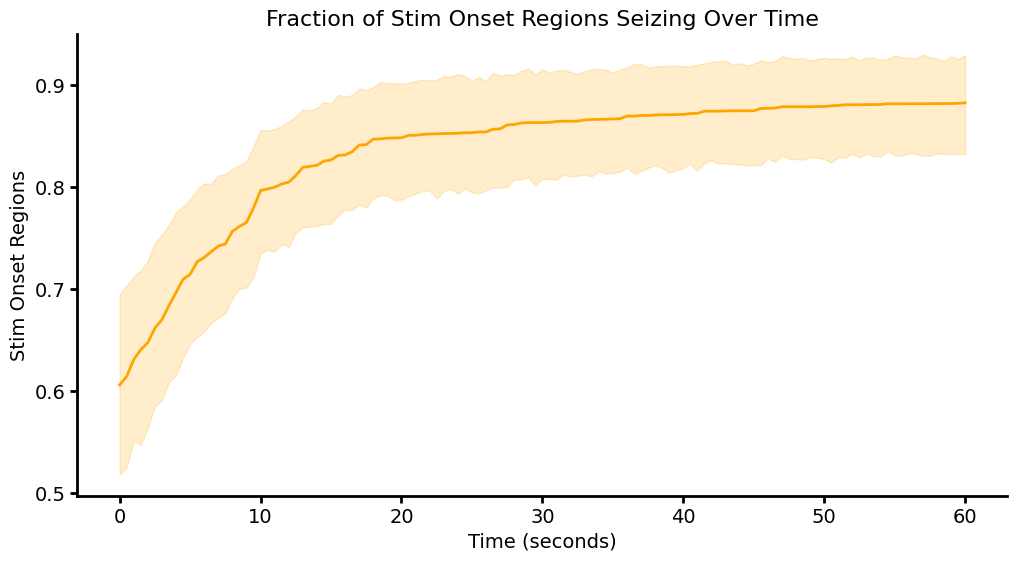

In [118]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=stim_spread_df_long, x='Time', y='Fraction',color='orange')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 0]['Fraction'].mean(),color='red',linestyle='--')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 15]['Fraction'].mean(),color='blue',linestyle='--')
plt.title('Fraction of Stim Onset Regions Seizing Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Stim Onset Regions')
sns.despine()
# plt.ylim((0,1))

#### Null modeling

Need to figure out what are the odds of a random selection of regions equal to the number of stim onset regions seizing at that time point. This should sample from the all_rs based on the number of stim UEO regions

In [119]:
set_seed(2358)
# Now need to iterate through patinets, then interate through seizures that are stim
all_pts = []
null_fraction_ts = []
for pt,group in sz_annots_rs.groupby("patient"):
    stim_szs = group[group.stim == 1]
    spont_szs = group[group.stim == 0]
    for idx,st_sz in stim_szs.iterrows():
        onset_locs = st_sz.ueo_rs_strict # can change to other channel types but this makes the most sense
        if len(onset_locs.shape) == 0:
            onset_locs = np.array([str(onset_locs)])
        null_n = len(onset_locs)
        for _ in range(50):
            if null_n == 0:
                null_locs = []
            else:
                sample_rs = np.array([r for r in np.atleast_1d(st_sz.all_rs) if r != 'EmptyLabel'])
                null_locs = sample_rs[np.random.randint(0,len(sample_rs),null_n)]
            null_st_sp_spreads = np.ones((len(spont_szs),len(null_locs)))*60000
            for j,(idx,sp_sz) in enumerate(spont_szs.iterrows()):
                # For each spontaneous seizure, find the time when the stim seizure onset regions start seizing (if ever)
                locs = sp_sz.sz_locs
                times = sp_sz.sz_loc_times
                # all_pts.append(pt) # SEIZURE LEVEL
                for k,st_loc in enumerate(null_locs):
                    loc_idx = st_loc == locs
                    if (loc_idx is not pd.NA) and (np.sum(loc_idx) > 0):
                        null_st_sp_spreads[j,k] = times[loc_idx]
            fraction_ts = calculate_fraction(null_st_sp_spreads)
            # null_fraction_ts.append(fraction_ts) # SEIZURE LEVEL
            null_fraction_ts.append(np.mean(fraction_ts,axis=0))
            all_pts.append(pt) 
null_spread_df = pd.DataFrame(np.array(null_fraction_ts),columns=time_points)
# null_spread_df = (null_spread_df > 0.5).astype(float)
# null_spread_df = pd.DataFrame(np.concatenate(null_fraction_ts,axis=0),columns=time_points) # SEIZURE LEVEL
null_spread_df['patient'] = all_pts
null_spread_df_long = null_spread_df.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')

In [120]:
is_sig = np.zeros((int(60.5/0.5),),dtype=bool)
for i,t in enumerate(np.arange(0,60.5,0.5)):
    stim_dist = stim_spread_df_long[stim_spread_df_long.Time == t]['Fraction']
    null_dist = null_spread_df_long[null_spread_df_long.Time == t]['Fraction']
    # pval = sc.stats.ttest_ind(stim_dist,null_dist,alternative='greater')[1]
    pval = (np.sum(null_dist > np.mean(stim_dist))+1)/(len(null_dist)+1)
    if pval < 0.05:
        is_sig[i] = True

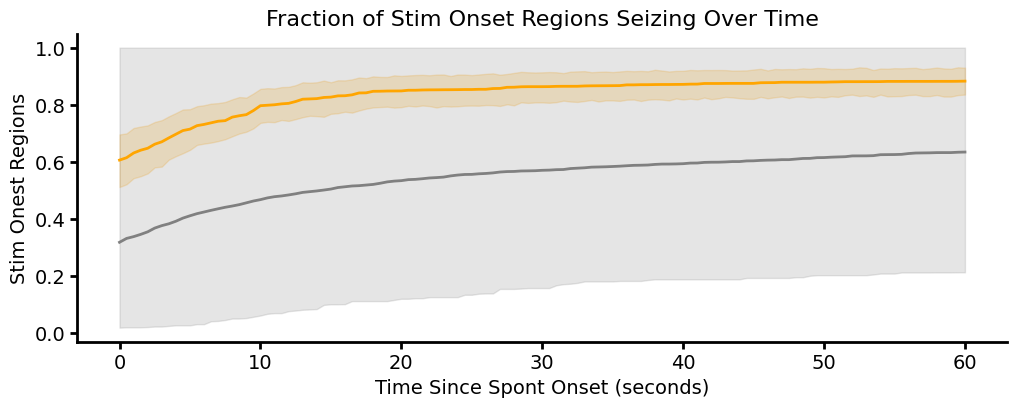

In [121]:
fig,ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=stim_spread_df_long, x='Time', y='Fraction',color='orange')
sns.lineplot(data=null_spread_df_long, x='Time', y='Fraction',color='grey',errorbar=lambda x: (np.percentile(x,5),np.percentile(x,95)))
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 0]['Fraction'].mean(),color='red',linestyle='--')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 15]['Fraction'].mean(),color='blue',linestyle='--')
plt.title('Fraction of Stim Onset Regions Seizing Over Time')
plt.xlabel('Time Since Spont Onset (seconds)')
plt.ylabel('Stim Onest Regions')
sns.despine()
# plt.xlim((0,15))
# plt.ylim((0,1))
# Plot horizontal bars at y = 0.05
# for i in range(len(is_sig) - 1):
#     if is_sig[i]:
#         if is_sig[i + 1]:
#             ax.hlines(1, time_points[i], time_points[i + 1], color='k', linewidth=2)
#         else:
#             ax.hlines(1, time_points[i], time_points[i], color='k', linewidth=2)
ymin,ymax = plt.ylim()
if sum(is_sig) > 0:
    star_x = np.where(is_sig)[0][0]
    plt.text(time_points[star_x],1.01,'*',fontsize='24',horizontalalignment='center')
    plt.vlines(time_points[star_x],ymin,1,ls='--',color='k')
plt.savefig(ospj(figpath,'stim_ueo_region_recruitment.pdf'),bbox_inches='tight')

#### Calculating fraction of onset regions at 5 seconds comparing null model to stim seizure onset to every other spontaneous seizure onset

In [122]:
# Now need to iterate through patients, then interate through seizures that are stim
all_pts = []
spont_fraction_ts = []
for pt,group in sz_annots_rs.groupby("patient"):
    spont_szs = group[group.stim == 0]
    print(pt)
    for idx,key_sz in spont_szs.iterrows():
        # Now, for each spontatneous seizure I want to iterate through each other spontaneous seizure:
        onset_locs = key_sz.ueo_rs_strict
        if len(onset_locs.shape) == 0:
            onset_locs = np.array([str(onset_locs)])
        
        all_st_sp_spreads = np.ones((len(spont_szs),len(onset_locs)))*60000
        for j,(idx,sp_sz) in enumerate(spont_szs.iterrows()):
            # For each spontaneous seizure, find the time when the stim seizure onset regions start seizing (if ever)
            locs = sp_sz.sz_locs
            times = sp_sz.sz_loc_times
            for k,key_loc in enumerate(onset_locs):
                loc_idx = key_loc == locs
                if (loc_idx is not pd.NA) and (np.sum(loc_idx) > 0):
                    all_st_sp_spreads[j,k] = times[loc_idx]
        fraction_ts = calculate_fraction(all_st_sp_spreads)
        if np.isnan(fraction_ts).any():
            continue
        # spont_fraction_ts.append(fraction_ts)
        # all_pts.append([pt]*len(fraction_ts))
        spont_fraction_ts.append(np.nanmean(fraction_ts,axis=0))
        all_pts.append(pt)

spont_spread_df = pd.DataFrame(np.array(spont_fraction_ts),columns=time_points)
# spont_spread_df = (spont_spread_df > 0.5).astype(float)
spont_spread_df['patient'] = all_pts
spont_spread_df_long = spont_spread_df.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')

CHOP005
CHOP024
CHOP026
CHOP028
CHOP035
CHOP037
CHOP041
CHOP044
CHOP045
CHOP049
HUP224
HUP225
HUP229
HUP230
HUP235
HUP238
HUP246
HUP247
HUP249
HUP250
HUP253
HUP257
HUP261
HUP263
HUP266
HUP267
HUP273
HUP275
HUP288


In [123]:
is_sig = np.zeros((int(60.5/0.5),),dtype=bool)
for i,t in enumerate(np.arange(0,60.5,0.5)):
    spont_dist = spont_spread_df_long[spont_spread_df_long.Time == 0]['Fraction']
    stim_dist = stim_spread_df_long[stim_spread_df_long.Time == t]['Fraction']
    pval = sc.stats.ttest_ind(spont_dist,stim_dist)[1]
    if pval < 0.05:
        is_sig[i] = True

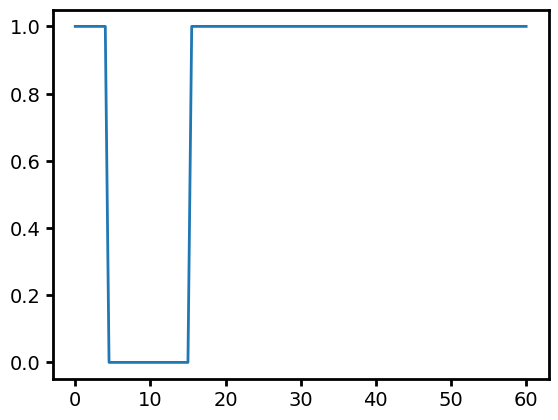

In [124]:
plt.plot(np.arange(0,60.5,0.5),is_sig)

60.0


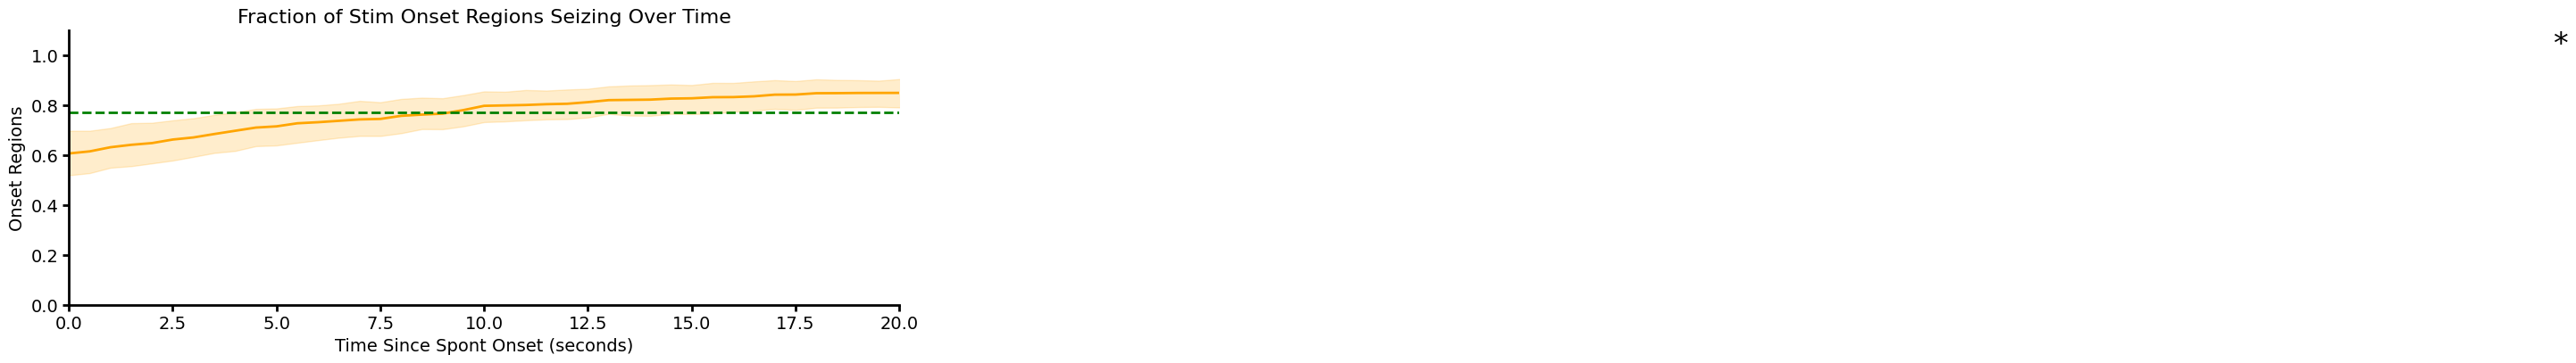

In [125]:
fig,ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=stim_spread_df_long, x='Time', y='Fraction',color='orange',linewidth=2,err_style='band')
# sns.lineplot(data=spont_spread_df_long, x='Time', y='Fraction',color='green',linewidth=2,err_style='band')
plotting_df = spont_spread_df_long.copy()
plotting_df = plotting_df[plotting_df.Time==0]
plotting_df.loc[:,'Time'] = -2
# sns.lineplot(data=null_spread_df_long, x='Time', y='Fraction',color='grey',linewidth=2)
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 0]['Fraction'].mean(),color='red',linestyle='--')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 15]['Fraction'].mean(),color='blue',linestyle='--')
plt.title('Fraction of Stim Onset Regions Seizing Over Time')
plt.xlabel('Time Since Spont Onset (seconds)')
plt.ylabel('Onset Regions')
sns.despine()
plt.xlim((0,20))
plt.ylim((0,1.1))
# Plot horizontal bars at y = 0.05
# for i in range(len(is_sig) - 1):
#     if is_sig[i]:
#         if is_sig[i + 1]:
#             ax.hlines(1, time_points[i], time_points[i + 1], color='k', linewidth=2)
#         else:
#             ax.hlines(1, time_points[i], time_points[i], color='k', linewidth=2)
star_x = np.where(is_sig)[0][-1]
print(time_points[star_x])
plt.text(time_points[star_x],1.01,'*',fontsize='24',horizontalalignment='center')
ymin,ymax = plt.ylim()
plt.vlines(time_points[star_x],ymin,1,ls='--',color='k')
plt.hlines(spont_spread_df_long[spont_spread_df_long.Time == 0]['Fraction'].mean(),0,60,colors='green',linestyles='--',linewidth=2)
plt.savefig(ospj(figpath,'spont-stim_ueo_region_recruitment.pdf'),bbox_inches='tight')

## Predicting Stim Seizure Similarity

### Calculating seizure level metadata

Make a dataframe with the following columns: Patient, stim seizure, spontaneous seizure, stim onset regions, spontaneous onset regions, kappa, stim seizure duration, hippocampal localization? 

273 is atypical

In [126]:
def model_seizure_similarity(annots,first_annot = 'ueo_consensus', second_annot = 'ueo_consensus',paired=True):
    annot_list = ["kappa","F1","MCC","patient","IEEGname","approximate_onset","stim_sz_length","stim_sz_spread"]
    annot_dict = {key:[] for key in annot_list}
    skip_pt = []
    for pt,group in annots.groupby("patient"):
        if (sum(group.stim == 0) < 2) and paired:
            skip_pt.append(pt)
            continue
        elif len(group) < 2:
            skip_pt.append(pt)
            continue
        # Iterate through each seizure
        for i in range(len(group)):
            group.reset_index(drop=True,inplace=True)
            ch_mask = group.loc[i,first_annot].reshape(-1,)
            if group.loc[i,'stim'] == 1:
                for j in range(len(group)):
                    if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
                        continue
                    ch_mask2 = group.loc[j,second_annot].reshape(-1,)
                    annot_dict["kappa"].append(cohen_kappa_score(ch_mask,ch_mask2))
                    annot_dict["F1"].append(f1_score(ch_mask,ch_mask2))
                    annot_dict["MCC"].append(matthews_corrcoef(ch_mask,ch_mask2))
                    annot_dict["patient"].append(pt)
                    annot_dict["IEEGname"].append(group.loc[i,'iEEG_ID'])
                    annot_dict["approximate_onset"].append(group.loc[i,'approximate_onset'])
                    annot_dict["stim_sz_length"].append(group.loc[i,'offset']-group.loc[i,'approximate_onset'])
                    annot_dict['stim_sz_spread'].append(len(group.loc[i,'sz_chs'])/len(group.loc[i,'all_channels']))
                    
    annot_df = pd.DataFrame(annot_dict)
    print(f"Skipped {skip_pt} due to insufficient spontaneous seizures")
    return annot_df

In [127]:
# model_dict = {key:[] for key in ['patient','onset','agreement','stim_sz_length','stim_sz_spread']}
# annot_type = 'ueo'
# con_type = 'strict'

# for pt,group in sz_annots.groupby('patient'):
#     group.sort_values(ascending=False,by='stim',inplace=True)
#     group.reset_index(drop=True,inplace=True)
#     for i in range(len(group)):
#         for j in range(i+1,len(group)):
#             if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
#                 continue
#             if (group.loc[i,'stim'] == 1)  or (group.loc[j,'stim'] == 1):
#                 all_rs = group.loc[i,'all_rs']
#                 chs = group.loc[i,f'{annot_type}_rs_{con_type}']
#                 ch_mask = np.array([l in chs for l in group.loc[i,'all_rs']])
#                 chs2 = group.loc[j,f'{annot_type}_rs_{con_type}']
#                 ch_mask2 = np.array([l in chs2 for l in group.loc[j,'all_rs']])
#                 model_dict['patient'].append(pt)
#                 model_dict['onset'].append(group.loc[i,'approximate_onset'])
#                 model_dict['agreement'].append(cohen_kappa_score(ch_mask,ch_mask2))
#                 model_dict['stim_sz_length'].append(group.loc[i,'offset']-group.loc[i,'approximate_onset'])
#                 model_dict['stim_sz_spread'].append(len(group.loc[i,'sz_chs'])/len(group.loc[i,'all_channels']))
# model_df = pd.DataFrame(model_dict)

In [128]:
model_df = model_seizure_similarity(sz_annots,first_annot='ueo_rs_strict_mask',second_annot='ueo_rs_strict_mask',paired = False)
model_df = model_df.rename(columns={'IEEGname':'iEEG_ID'})
model_df = model_df.sort_values('approximate_onset')

Skipped [] due to insufficient spontaneous seizures


In [129]:
model_df_wtypical = pd.merge_asof(model_df,
                                    seizures_df[['approximate_onset','patient',"iEEG_ID","to_annotate","typical"]],
                                    on='approximate_onset',by=['patient','iEEG_ID'],
                                    tolerance = 240,
                                    direction='nearest')

In [130]:
model_df_wtypical.typical = model_df_wtypical.typical == 1

In [131]:
metadata_table = pd.read_csv(ospj(metapath,'stim_seizure_information - metadata-2.csv')).loc[:,["record_id","hupsubjno",
                                                                                            "Laterality","unifocal",
                                                                                            "localization","duration",
                                                                                            "outcome","lesional"]]
metadata_table['stim_sz'] = metadata_table['hupsubjno'].apply(int).isin(patient_table.ptID.apply(lambda x: int(x[3:])))
metadata_table['mtle'] = metadata_table.localization.apply(lambda x: 'MTLE' in x if not isinstance(x,float) else False)
# metadata_table['mtle'] = metadata_table.localization == 'MTLE'
metadata_table["unifocal"] = metadata_table.unifocal == 1
metadata_table["lesional"] = metadata_table.lesional > 0
metadata_table["ptID"] = "HUP" + metadata_table["hupsubjno"].astype(str)
# metadata_table.loc[metadata_table.unifocal == 0,'mtle'] = pd.NA
metadata_table.head()

,record_id,hupsubjno,Laterality,unifocal,localization,duration,outcome,lesional,stim_sz,mtle,ptID
0,650,211,3,False,MTLE,11.3,NaN,True,False,True,HUP211
1,651,212,4,False,NaN,13.9,NaN,True,False,False,HUP212
2,649,213,1,True,MTLE,19.1,NaN,True,False,True,HUP213
3,652,214,3,False,MTLE,8.6,NaN,False,False,True,HUP214
4,658,216,1,True,Other,21.1,1.0,False,False,False,HUP216


In [132]:
kiddata_table = pd.read_csv(ospj(metapath,'CHOP_metadata.csv'))
kiddata_table['duration'] = kiddata_table['duration of epilepsy prior to stim (y)']
kiddata_table['unifocal'] = kiddata_table.unifocal == 1
kiddata_table['mtle'] = kiddata_table.mtle == 1
kiddata_table['lesional'] = kiddata_table.lesional == 1
kiddata_table.head()

,ptID,stim_sz,unifocal,mtle,lesional,sex,outcome,precise age at time of recording (y),handedness,age at epilepsy onset,...,Engel outcome year 2,ILAE outcome year 2,current Engel,current ILAE,seizure reduction with neuro-modulation,time since neuro-modulation implant (y),follow up interval post resection (y),>2y follow up after surgery?,>1y follow up after surgery,duration
0,CHOP001,0,False,False,True,F,1.0,15.493151,R,14.00,...,1A,1.0,1A,1.0,100%,2.398357,NaN,no,no,1.493151
1,CHOP002,0,True,False,False,M,NaN,19.956164,R suspected pre surgery,9.00,...,NaN,NaN,1A,1.0,NaN,NaN,1.054073,no,yes,10.956164
2,CHOP003,0,True,False,True,M,1.0,3.704110,R,0.42,...,1A,1.0,1A,1.0,NaN,NaN,5.264887,yes,yes,3.284110
3,CHOP004,0,True,True,True,F,1.0,12.558904,R,6.00,...,1A,1.0,1B,3.0,NaN,NaN,4.720055,yes,yes,6.558904
4,CHOP005,1,False,False,True,F,1.0,4.287671,L,3.00,...,1A,1.0,1A,1.0,NaN,NaN,4.454483,yes,yes,1.287671


In [133]:
all_metadata_table = pd.concat((metadata_table,kiddata_table))[['ptID','unifocal','mtle','outcome','duration','lesional']]
all_metadata_table['adult'] = all_metadata_table.ptID.apply(lambda x: 'HUP' in x)
all_metadata_table.head()

,ptID,unifocal,mtle,outcome,duration,lesional,adult
0,HUP211,False,True,NaN,11.3,True,True
1,HUP212,False,False,NaN,13.9,True,True
2,HUP213,True,True,NaN,19.1,True,True
3,HUP214,False,True,NaN,8.6,False,True
4,HUP216,True,False,1.0,21.1,False,True


In [134]:
# Join the two tables and make linear model!
lm_df = pd.merge(model_df_wtypical,all_metadata_table[['ptID','mtle','outcome','unifocal','lesional','adult']],left_on='patient',right_on='ptID',how='inner').drop('ptID',axis=1)

In [135]:
combiner=75
def percentile(x,combiner=combiner):
    return np.percentile(x,combiner,method='linear')
lm_df_grouped = lm_df.groupby('approximate_onset')
lm_df_left = lm_df_grouped[[l for l in lm_df.columns if l not in ['MCC','F1','kappa']]].max()
lm_df_left['MCC'] = lm_df_grouped['MCC'].apply(percentile)
lm_df_left['F1'] = lm_df_grouped['F1'].apply(percentile)
lm_df_left['kappa'] = lm_df_grouped['kappa'].apply(percentile)
lm_df_left.reset_index(drop=True,inplace=True)

In [136]:
lm_df_left.dropna(axis=0,subset=['MCC','F1','mtle','unifocal','typical','lesional'],how='any',inplace=True)
lm_df_left.head()

,patient,iEEG_ID,approximate_onset,stim_sz_length,stim_sz_spread,to_annotate,typical,mtle,outcome,unifocal,lesional,adult,MCC,F1,kappa
0,HUP229,HUP229_phaseII,1109.40,67.51,0.390244,1.0,True,True,0.0,True,True,True,0.518545,0.666667,0.511628
1,CHOP035,CHOPCCEP_035,2872.35,26.71,0.145349,1.0,True,True,NaN,True,True,False,0.430331,0.500000,0.312500
2,CHOP026,CHOPCCEP_026,3608.77,133.79,0.410000,NaN,False,True,1.0,False,False,False,1.000000,1.000000,1.000000
3,HUP230,HUP230_phaseII,3860.24,18.16,0.132075,1.0,True,True,1.0,True,True,True,0.679366,0.666667,0.631579
4,CHOP026,CHOPCCEP_026,4838.94,37.90,0.290000,1.0,True,True,1.0,False,False,False,0.450694,0.400000,0.337662


In [137]:
len(lm_df_left)

41

### Univariate analyses

#### All

MannwhitneyuResult(statistic=252.5, pvalue=0.12194995174566352)


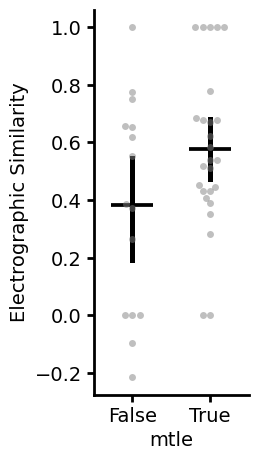

MannwhitneyuResult(statistic=280.5, pvalue=0.032079568304665414)


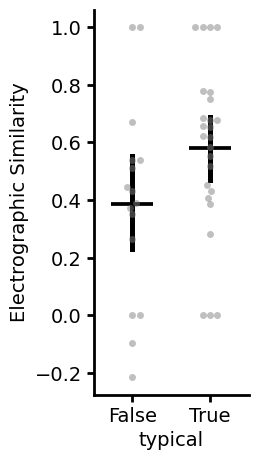

MannwhitneyuResult(statistic=135.0, pvalue=0.26876750880413536)


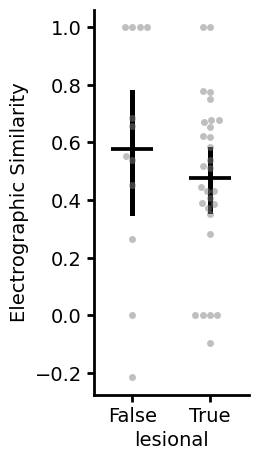

SignificanceResult(statistic=0.27649484223083937, pvalue=0.08012253020531945)


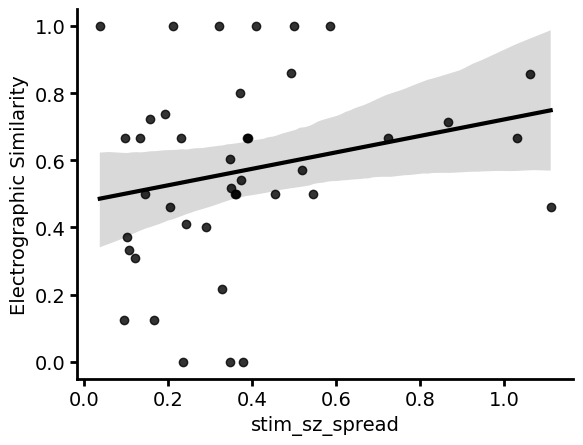

SignificanceResult(statistic=-0.09018227850047308, pvalue=0.5749780751862049)


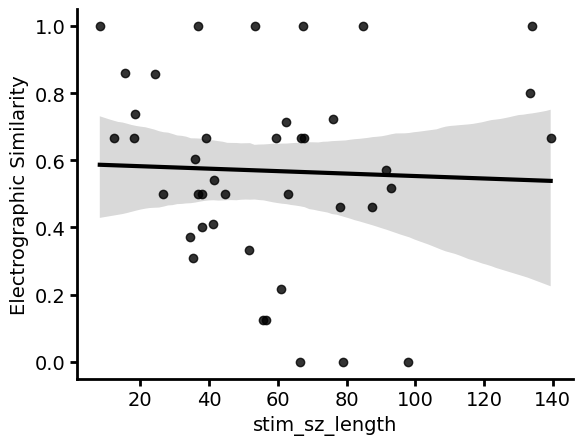

In [138]:
for col in ['mtle','typical','lesional','stim_sz_spread','stim_sz_length']:
    if lm_df_left[col].nunique() <= 3:
        print(sc.stats.mannwhitneyu(lm_df_left[lm_df_left[col]]['MCC'],lm_df_left[~lm_df_left[col]]['MCC']))
        _,ax = plt.subplots(figsize=(2,5))
        sns.swarmplot(lm_df_left,x=col,y='MCC',color='gray',alpha=0.5)
        sns.pointplot(lm_df_left,x=col,y='MCC',marker='_',linestyles='none',markersize=30,color='black')
        plt.ylabel('Electrographic Similarity')
        sns.despine()

    else:
        print(sc.stats.spearmanr(lm_df_left[col].values,lm_df_left['F1'].values))
        sns.regplot(lm_df_left,x=col,y='F1',color='black')
        plt.ylabel('Electrographic Similarity')
        sns.despine()

    plt.show()


#### By center

MannwhitneyuResult(statistic=152.5, pvalue=0.20448296149897693)
MannwhitneyuResult(statistic=100.0, pvalue=0.17347857884878082)


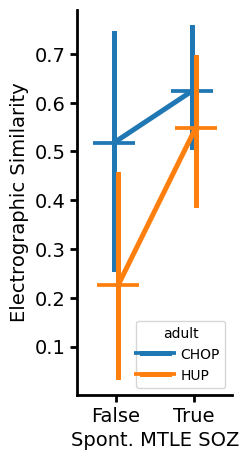

MannwhitneyuResult(statistic=124.0, pvalue=0.19980559346195603)
MannwhitneyuResult(statistic=156.5, pvalue=0.02238750285831503)


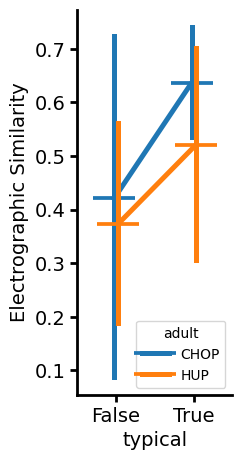

MannwhitneyuResult(statistic=80.0, pvalue=0.17248743191336136)
MannwhitneyuResult(statistic=55.0, pvalue=0.7653895074797594)


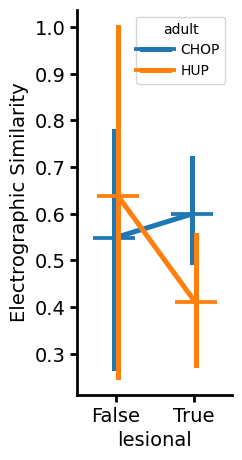

In [139]:
plot_df = lm_df_left.copy()
plot_df['adult'] = plot_df.adult.map({True:'HUP',False:'CHOP'})
for col in ['mtle','typical','lesional','stim_sz_spread','stim_sz_length']:
    if lm_df_left[col].nunique() <= 3:

        print(sc.stats.mannwhitneyu(lm_df_left[lm_df_left.adult][lm_df_left[col]]['MCC'],lm_df_left[~lm_df_left[col]]['MCC']))
        print(sc.stats.mannwhitneyu(lm_df_left[~lm_df_left.adult][lm_df_left[col]]['MCC'],lm_df_left[~lm_df_left[col]]['MCC']))
        _,ax = plt.subplots(figsize=(2,5))
        # sns.swarmplot(lm_df_left,x=col,y='MCC',hue='adult',alpha=0.5,dodge=True)
        sns.pointplot(plot_df,x=col,y='MCC',marker='_',markersize=30,hue='adult',dodge=True)
        plt.ylabel('Electrographic Similarity')
        sns.despine()
        if col == 'mtle':
            plt.xlabel('Spont. MTLE SOZ')
    plt.show()

### Recursive modeling

0.014168556539172705 Intercept           3.402542
adult[T.True]      -0.550644
lesional[T.True]   -1.008215
typical[T.True]     1.469232
stim_sz_length     -0.769371
stim_sz_spread      0.690191
dtype: float64
0.03324963195589892 Intercept           3.390811
lesional[T.True]   -1.259004
typical[T.True]     1.662526
stim_sz_length     -0.866832
stim_sz_spread      0.650511
dtype: float64
0.0483214229946769 Intercept           3.410525
lesional[T.True]   -1.133689
typical[T.True]     1.904055
stim_sz_length     -0.652159
dtype: float64
0.06271400847953068 Intercept           4.277374
lesional[T.True]   -1.017333
typical[T.True]     1.942545
dtype: float64
0.061873664701094344 Intercept          4.920563
typical[T.True]    1.907402
dtype: float64


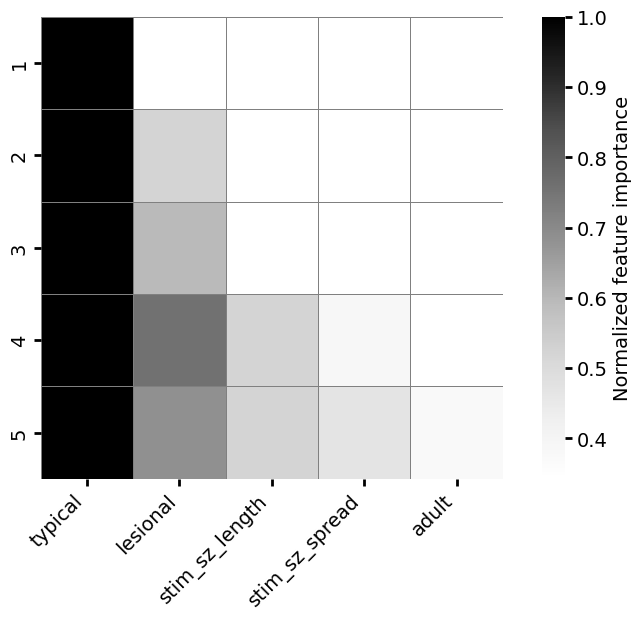

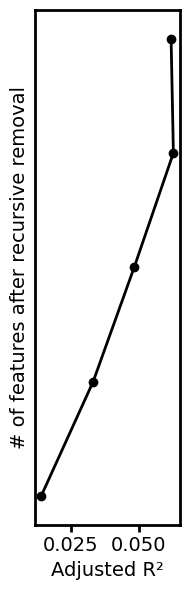

-0.09039178832637385 Intercept           1.134480
lesional[T.True]    0.252975
typical[T.True]     1.258699
stim_sz_length      0.478214
stim_sz_spread     -0.832565
dtype: float64
-0.01749101285591692 Intercept          1.592168
typical[T.True]    1.303357
stim_sz_length     0.431019
stim_sz_spread    -0.858588
dtype: float64
0.03773992479244115 Intercept          2.926283
typical[T.True]    1.358156
stim_sz_spread    -0.775092
dtype: float64
0.06175022599144697 Intercept          3.343599
typical[T.True]    1.455624
dtype: float64


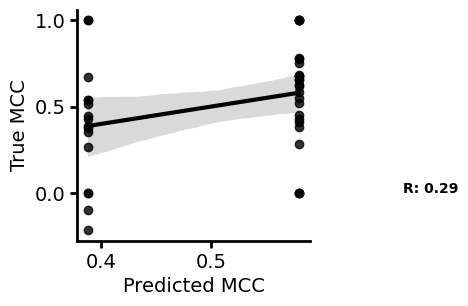

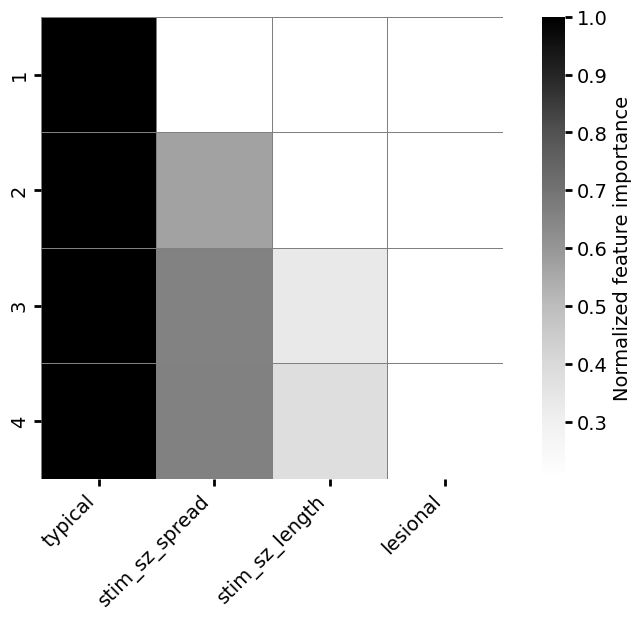

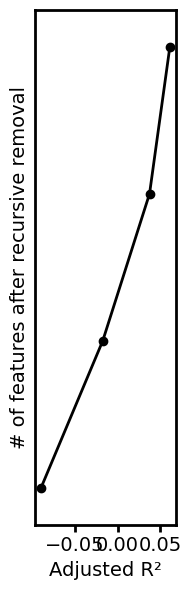

-0.032350849412250415 Intercept           2.314962
lesional[T.True]   -1.126227
typical[T.True]     0.266297
stim_sz_length     -0.300920
stim_sz_spread      1.152861
dtype: float64
0.018130349755629438 Intercept           2.485768
lesional[T.True]   -1.303811
stim_sz_length     -0.229223
stim_sz_spread      1.364731
dtype: float64
0.06464430912607788 Intercept           2.767289
lesional[T.True]   -1.354101
stim_sz_spread      1.411563
dtype: float64
0.027515568405773294 Intercept         2.650938
stim_sz_spread    1.273762
dtype: float64


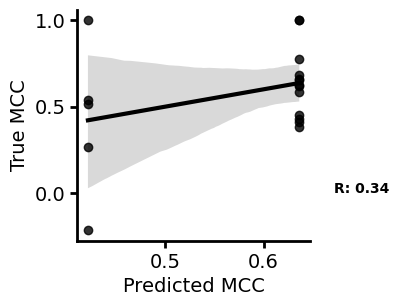

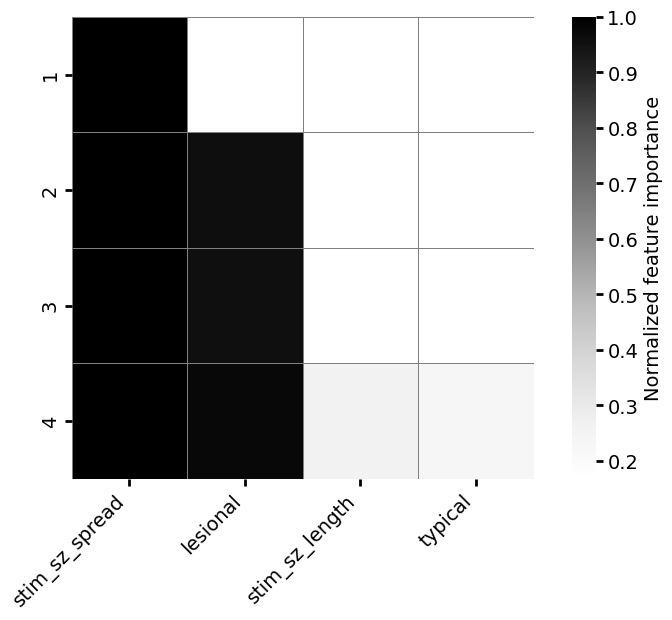

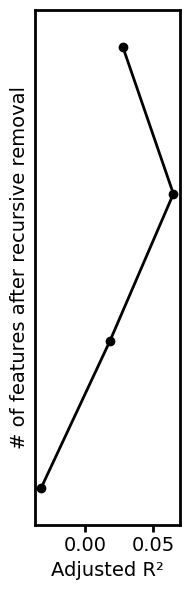

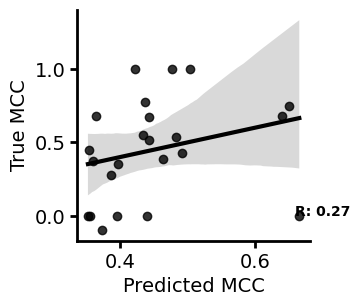

In [140]:
for mask in [[True]*len(lm_df_left),lm_df_left.adult==False, lm_df_left.adult==True]:
    dat = lm_df_left[mask].copy()
    
    if dat.adult.nunique() == 2:
        all_vars = ['adult','lesional', 'typical', 'stim_sz_length', 'stim_sz_spread']
    else:
        all_vars = ['lesional', 'typical', 'stim_sz_length', 'stim_sz_spread']

    dat = dat[all_vars+['MCC']]
    remaining_vars = all_vars.copy()

    # Store results
    adj_r2_list = []
    var_list = []
    tval_history = {}

    # Recursive elimination
    while len(remaining_vars) > 0:
        var_list.append(remaining_vars)
        formula = 'MCC ~ ' + ' + '.join(remaining_vars)
        results = smf.ols(formula, data=dat).fit()

        adj_r2_list.append(results.rsquared_adj)
        tvals = results.tvalues.drop('Intercept').abs()
        tvals = results.tvalues.drop('Intercept').abs()
        print(results.rsquared_adj,results.tvalues)
        # Map the true variable names
        mapped_tvals = {}
        for k, v in tvals.items():
            base = k.split('[')[0] if '[' in k else k
            mapped_tvals[base] = v

        # Reindex to keep consistent order and NaNs for dropped vars
        tval_history[len(remaining_vars)] = pd.Series(mapped_tvals).reindex(all_vars)

        # Drop least important feature
        if len(remaining_vars) > 1:
            to_remove = tvals.idxmin()
            if 'True' in to_remove:
                to_remove = to_remove.split('[')[0]
            remaining_vars.remove(to_remove)
        else:
            break

    # Create tval_df with fixed columns up front
    tval_df = pd.DataFrame.from_dict(tval_history, orient='index')[all_vars]
    tval_df.index = range(len(tval_df), 0, -1)

    # Normalize row-wise (preserves NaNs)
    tval_df_norm = tval_df.div(tval_df.max(axis=1), axis=0)
    # Build triangular mask
    # mask = np.triu(np.ones_like(tval_df_norm.values, dtype=bool), k=1)
    # Sort columns by their column-wise sum (descending)
    tval_df_norm = tval_df_norm[tval_df_norm.sum(axis=0).sort_values(ascending=False).index]

    # Invert the rows (e.g., from bottom to top)
    tval_df_norm = tval_df_norm.iloc[::-1]
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    # Heatmap of normalized t-values (importance)
    sns.heatmap(
        tval_df_norm,
        cmap='Greys',
        linewidths=0.5,
        linecolor='grey',
        square=True,
        cbar_kws={'label': 'Normalized feature importance'},
        xticklabels=tval_df_norm.columns,
        yticklabels=[f'{i}' for i in tval_df_norm.index],
        ax=ax
    )
    # ax.set_ylabel('# of features after recursive removal')
    ax.set_ylabel('')
    ax.set_xlabel('')
    plt.xticks(rotation=45, ha='right')

    fig, ax2 = plt.subplots(figsize=(2, 6))
    # Add R² curve
    ax2.plot(adj_r2_list, np.arange(len(adj_r2_list))+0.5, 'o-', color='black')
    plt.yticks([])
    # ax2.set_xlim(0.1, .3)
    ymax = len(adj_r2_list)-.25
    ax2.set_ylim([0.25,ymax])
    ax2.set_xlabel('Adjusted R²')
    ax2.set_ylabel('# of features after recursive removal')
    plt.tight_layout()
    plt.show()

    best_features = var_list[np.argmax(adj_r2_list)]
    formula = 'MCC ~ ' + ' + '.join(best_features)
    results = smf.ols(formula, data=dat).fit()
    predicted_mcc = results.predict(dat)
    fig,ax3 = plt.subplots(figsize=(3,3))
    # ax3.scatter(predicted_mcc,dat.MCC,c='k')
    sns.regplot(x=predicted_mcc,y=dat.MCC,color='black')
    ax3.set_xlabel('Predicted MCC')
    ax3.set_ylabel('True MCC')
    # ax3.plot([0,1],[0,1],c='k',linestyle='--')
    # plt.ylim([-.2,1.1])
    # plt.xlim([-.2,1.1])
    ax3.text(0.7,0, f'R: {np.round(np.corrcoef(predicted_mcc,dat.MCC.values)[0][1],2)}',fontweight='bold',ha='center')
    sns.despine()

### MVLM function

In [141]:
def plot_linear_models(dat,variables,subset=''):
    formula = 'MCC ~ ' + ' + '.join(variables)
    results = smf.ols(formula, data=dat).fit()
    print(results.summary())
    tvals = results.tvalues
    pvals = results.pvalues
    lm_vars = results.params.index
    lm_vars = [var.split('[')[0] if '[' in var else var for var in lm_vars]

    data = {
    'Variable': lm_vars,
    't_statistic': tvals,
    'significant': pvals
    }

    df = pd.DataFrame(data)

    palette = [sig_color(pval) for pval in df['significant']][1:]
    # plot_order = ['Intercept','mtle[T.True]','unifocal[T.True]','typical[T.True]','stim_sz_length','stim_sz_spread']
    # Plotting
    fig,ax = plt.subplots(figsize=(5, 6))
    sns.barplot(
        data=df,
        y='Variable',
        x='t_statistic',
        palette=palette,
        # palette = ['blue','blue','blue','blue','blue'],
        orient='h',
        order=variables,
    )

    # Add a vertical line at t = 0 for reference
    plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
    plt.xlabel('t-statistic')
    plt.ylabel('')
    if len(subset) > 0:
        plt.title(f'Predicting Electrographic Similarity ({subset})')
    else:
        plt.title('Predicting Electrographic Similarity')
    # plt.yticks(plt.yticks()[0],['mTLE SOZ','Lesional','Unifocal','Typical','Sz Length','Sz Spread'])
    # plt.yticks(plt.yticks()[0],['Lesional','Typical','Sz Length','Sz Spread'])
    plt.yticks(plt.yticks()[0],variables)
    plt.text(0.7,0.9,f'$Adj. R^2$: {np.round(results.rsquared_adj,2)}',transform=ax.transAxes,ha='left',va='bottom',fontsize=14)
    sns.despine()


### Applying MVLM

#### All

In [142]:
plot_linear_models(lm_df_left,['lesional','typical','stim_sz_length','stim_sz_spread'])

                            OLS Regression Results                            
Dep. Variable:                    MCC   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     1.344
Date:                Tue, 29 Apr 2025   Prob (F-statistic):              0.273
Time:                        13:31:11   Log-Likelihood:                -8.8124
No. Observations:                  41   AIC:                             27.62
Df Residuals:                      36   BIC:                             36.19
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.5390      0.159  

NameError: name 'sig_color' is not defined

                            OLS Regression Results                            
Dep. Variable:                    MCC   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     2.778
Date:                Tue, 29 Apr 2025   Prob (F-statistic):             0.0325
Time:                        11:42:40   Log-Likelihood:                -8.4411
No. Observations:                  41   AIC:                             28.88
Df Residuals:                      35   BIC:                             39.16
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.6000      0.165  

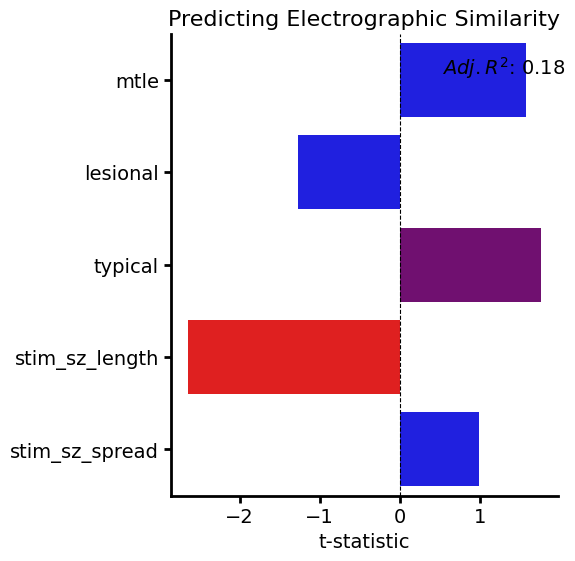

In [ ]:
plot_linear_models(lm_df_left,['mtle','lesional','typical','stim_sz_length','stim_sz_spread'])

#### Just HUP

                            OLS Regression Results                            
Dep. Variable:                    MCC   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.8864
Date:                Tue, 29 Apr 2025   Prob (F-statistic):              0.492
Time:                        11:42:54   Log-Likelihood:                -8.2930
No. Observations:                  23   AIC:                             26.59
Df Residuals:                      18   BIC:                             32.26
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.4534      0.255  

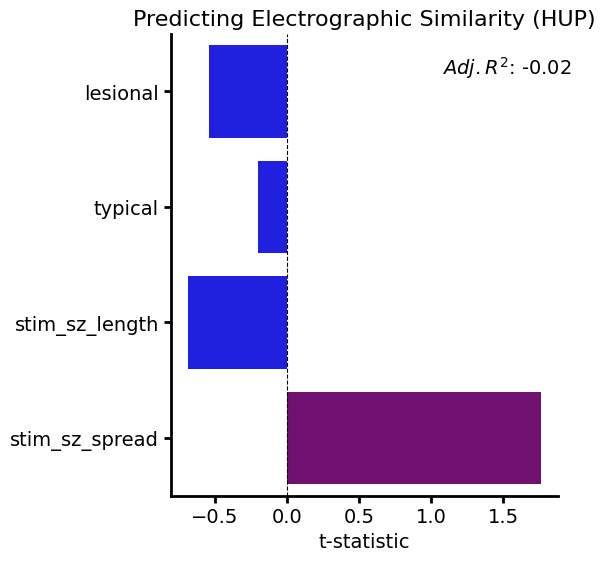

In [ ]:
plot_linear_models(lm_df_left[lm_df_left.adult],['lesional','typical','stim_sz_length','stim_sz_spread'],subset='HUP')

                            OLS Regression Results                            
Dep. Variable:                    MCC   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     1.853
Date:                Tue, 29 Apr 2025   Prob (F-statistic):              0.156
Time:                        11:42:54   Log-Likelihood:                -5.3571
No. Observations:                  23   AIC:                             22.71
Df Residuals:                      17   BIC:                             29.53
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3572      0.235  

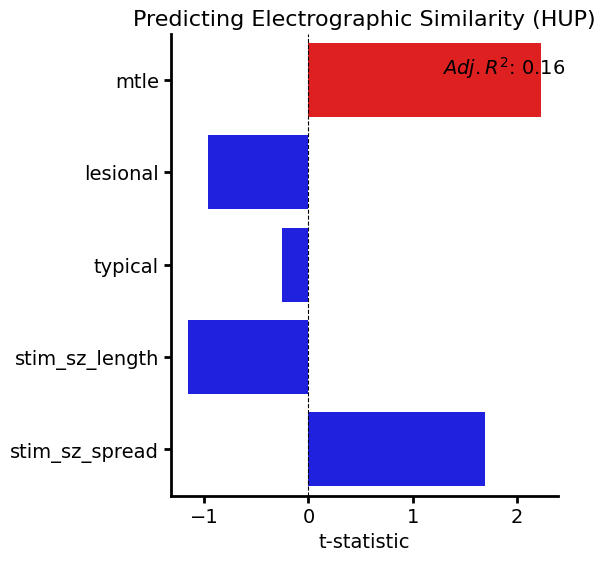

In [ ]:
plot_linear_models(lm_df_left[lm_df_left.adult],['mtle','lesional','typical','stim_sz_length','stim_sz_spread'],subset='HUP')

#### Just CHOP

                            OLS Regression Results                            
Dep. Variable:                    MCC   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     6.429
Date:                Tue, 29 Apr 2025   Prob (F-statistic):            0.00441
Time:                        11:43:06   Log-Likelihood:                 7.2043
No. Observations:                  18   AIC:                            -4.409
Df Residuals:                      13   BIC:                           0.04331
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.8532      0.224  

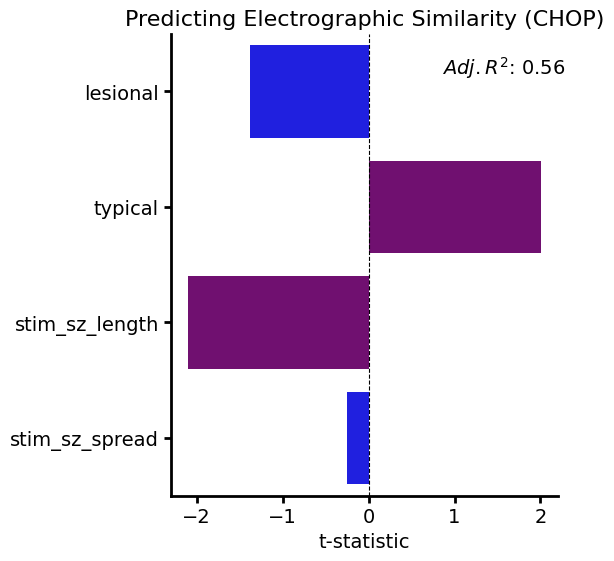

In [ ]:
plot_linear_models(lm_df_left[~lm_df_left.adult],['lesional','typical','stim_sz_length','stim_sz_spread'],subset='CHOP')

                            OLS Regression Results                            
Dep. Variable:                    MCC   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     4.811
Date:                Tue, 29 Apr 2025   Prob (F-statistic):             0.0121
Time:                        11:43:07   Log-Likelihood:                 7.2840
No. Observations:                  18   AIC:                            -2.568
Df Residuals:                      12   BIC:                             2.774
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.8804      0.247  

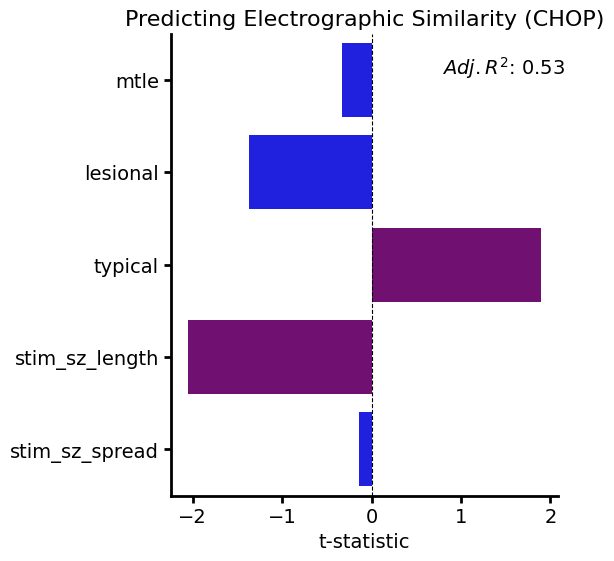

In [ ]:
plot_linear_models(lm_df_left[~lm_df_left.adult],['mtle','lesional','typical','stim_sz_length','stim_sz_spread'],subset='CHOP')